In [1]:
%load_ext autoreload
%load_ext autotime
%autoreload 2

## Imports & Settings

In [2]:
import os, sys
import warnings

# setting project path
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

# disabling log messages from TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# creating an end of run alarm
from IPython.display import Audio
sound_file = '/Users/dsbox/Documents/Flatiron/phase_5/WAILERLP.wav'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
%matplotlib inline

# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette('GnBu_r')
pd.options.display.max_rows = 300

from src import helper_functions as f
from src import visualizations as v
from src import class_Database as d
# from src import class_DatabaseF as dbf
from src import class_Harness as h

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline 
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             f1_score, make_scorer, confusion_matrix)
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC 
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.ensemble import (BaggingClassifier, AdaBoostClassifier,
                              RandomForestClassifier, VotingClassifier)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_sm_pipeline

# import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

from keras import layers, models, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

time: 15.8 s


## Creating The Database

In [3]:
# creating database & database class instance
database_name = 'outcomes.db'
db = d.Database(database_name)

time: 1.5 ms


**Run The Cell Below Once And Then Comment Out**

In [4]:
# file_name = 'anonymisedData.zip'
# db.populate(file_name, database_name)

time: 742 µs


### Database ERD

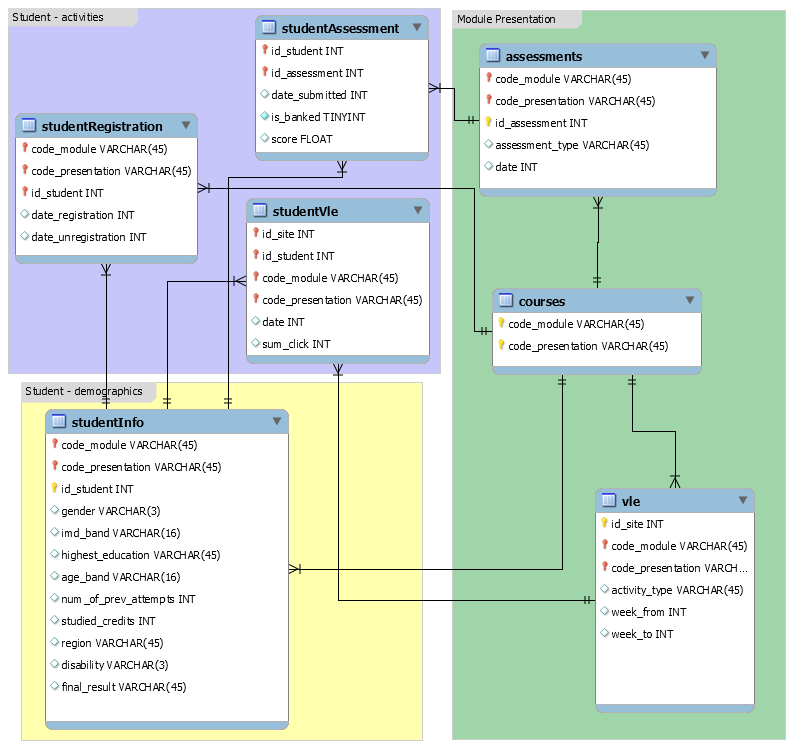

time: 3.94 ms


In [5]:
db.erd

## Preprocessing and Harness Objects

In [6]:
string_selector = make_column_selector(dtype_include='object')
number_selector = make_column_selector(dtype_include='number', dtype_exclude='object')

preprocessing_ohe = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector))
preprocessing_ss = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (StandardScaler(), number_selector))
preprocessing_mm = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (MinMaxScaler(), number_selector))
sm = SMOTE(random_state=2021)

time: 1.71 ms


In [7]:
# creating accuracy scorer
accuracy = f.acc_score

# creating f1 scorer
f1 = f.f1

# creating recall scorer 
recall = f.recall

# creating precision scorer
precision = f.precision

# creating Harness
modeling = h.Harness(('accuracy', 'f1', 'recall', 'precision'))

time: 3.42 ms


# STUDENTINFO Data

In [8]:
db.table_info('STUDENTINFO')

[(0, 'code_module', 'TEXT', 0, None, 0),
 (1, 'code_presentation', 'TEXT', 0, None, 0),
 (2, 'id_student', 'TEXT', 0, None, 0),
 (3, 'gender', 'TEXT', 0, None, 0),
 (4, 'region', 'TEXT', 0, None, 0),
 (5, 'highest_education', 'TEXT', 0, None, 0),
 (6, 'imd_band', 'TEXT', 0, None, 0),
 (7, 'age_band', 'TEXT', 0, None, 0),
 (8, 'num_of_prev_attempts', 'TEXT', 0, None, 0),
 (9, 'studied_credits', 'TEXT', 0, None, 0),
 (10, 'disability', 'TEXT', 0, None, 0),
 (11, 'final_result', 'TEXT', 0, None, 0)]

time: 3.58 ms


## Creating STUDENTINFO Data Frame

In [9]:
df = db.student_info_full()

time: 266 ms


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   target                32593 non-null  int64 
 1   row_id                32593 non-null  object
 2   code_module           32593 non-null  object
 3   code_presentation     32593 non-null  object
 4   id_student            32593 non-null  object
 5   gender                32593 non-null  object
 6   region                32593 non-null  object
 7   highest_education     32593 non-null  object
 8   imd_band              31482 non-null  object
 9   age_band              32593 non-null  object
 10  num_of_prev_attempts  32593 non-null  int64 
 11  studied_credits       32593 non-null  int64 
 12  disability            32593 non-null  object
 13  final_result          32593 non-null  object
dtypes: int64(3), object(11)
memory usage: 3.5+ MB
time: 26.6 ms


In [11]:
df.head()

,target,row_id,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,0,AAA2013J11391,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,0,AAA2013J28400,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,1,AAA2013J30268,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,0,AAA2013J31604,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,0,AAA2013J32885,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


time: 14.9 ms


In [12]:
df = db.sql_fixes(df)

time: 23.6 ms


In [13]:
drops = ['row_id', 'code_module', 'code_presentation',
         'id_student', 'final_result', 'studied_credits']

time: 773 µs


In [14]:
df = db.cleaner_studentinfo(df, drops)

time: 59.8 ms


In [15]:
df.target.value_counts(normalize=True)

1    0.531724
0    0.468276
Name: target, dtype: float64

time: 4.47 ms


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31144 entries, 1 to 32592
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   target                31144 non-null  int64   
 1   gender                31144 non-null  object  
 2   region                31144 non-null  object  
 3   highest_education     31144 non-null  object  
 4   imd_band              31144 non-null  object  
 5   age_band              31144 non-null  object  
 6   num_of_prev_attempts  31144 non-null  int64   
 7   disability            31144 non-null  object  
 8   course_load           31144 non-null  category
dtypes: category(1), int64(2), object(6)
memory usage: 2.2+ MB
time: 25.7 ms


## Creating Holdout Data

In [17]:
# splitting data & target
X, y = f.X_y(df)

time: 3.29 ms


In [18]:
# splitting training and holdout data
X_training, X_holdout, y_training, y_holdout = f.test_train(X, y)

time: 17.1 ms


## Creating Training Data

In [19]:
X_train, X_test, y_train, y_test = f.test_train(X_training, y_training)

time: 13.4 ms


## Baseline Model: Dummy Classifier

In [20]:
dummy = DummyClassifier(strategy='most_frequent')

time: 1.12 ms


In [21]:
baseline = make_pipeline(preprocessing_ohe, dummy)

time: 892 µs


### Fitting Model

In [22]:
baseline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1029b55b0>)])),
                ('dummyclassifier', DummyClassifier(strategy='most_frequent'))])

time: 62.1 ms


### Saving Model

In [23]:
# f.pickle_model(baseline, 'baseline')

time: 910 µs


### Cross Val Scores

In [24]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    modeling.report(baseline, X_train, y_train, ' Baseline', 'Baseline DummyCFL')

 Baseline has an average Accuracy of 0.5317387933630273
 Baseline has an average F1 of 0.6942943448460349
 Baseline has an average Recall of 1.0
 Baseline has an average Precision of 0.5317387933630273
time: 318 ms


### Test Data Confusion Matrix

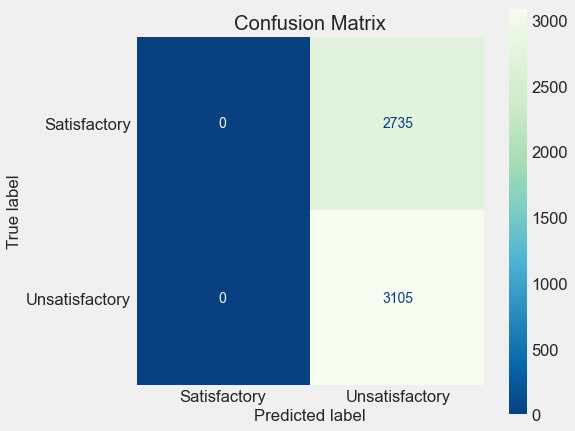

,Accuracy,F1,Recall,Precision
0,0.531678,0.694243,1.0,0.531678


time: 374 ms


In [25]:
%%capture --no-display
f.confusion_report(baseline, X_test, y_test, 'baseline')

## First Simple Model: Naive Bayes Classifier

In [26]:
mnb = MultinomialNB()

time: 723 µs


In [27]:
fsm = make_pipeline(preprocessing_ohe, mnb)

time: 1.78 ms


### Fitting Model

In [28]:
fsm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1029b55b0>)])),
                ('multinomialnb', MultinomialNB())])

time: 54.6 ms


### Saving Model

In [29]:
# f.pickle_model(fsm, 'fsm')

time: 672 µs


### Cross Val Scores

In [30]:
# checking cross val scores
modeling.report(fsm, X_train, y_train, ' fsm', 'FSM Naive Bayes')

 fsm has an average Accuracy of 0.5853974805678629
 fsm has an average F1 of 0.6304744503985316
 fsm has an average Recall of 0.6651637144390768
 fsm has an average Precision of 0.5992823091166359


[0.5853974805678629,
 0.6304744503985316,
 0.6651637144390768,
 0.5992823091166359]

time: 305 ms


### Test Data Confusion Matrix

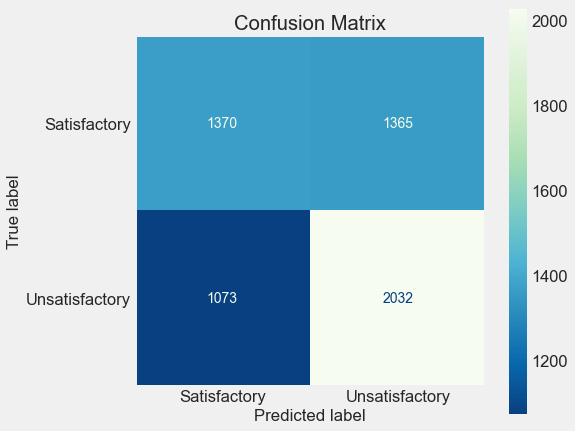

,Accuracy,F1,Recall,Precision
0,0.582534,0.625038,0.654428,0.598175


time: 381 ms


In [31]:
f.confusion_report(fsm, X_test, y_test, 'fsm')

## KNeighborsClassifier

In [32]:
KNN = KNeighborsClassifier(n_jobs=-1)

time: 915 µs


In [33]:
knn = make_pipeline(preprocessing_ohe, KNN)

time: 942 µs


### Fitting Model

In [34]:
knn.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1029b55b0>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1))])

time: 62.9 ms


In [35]:
# f.pickle_model(knn, 'knn')

time: 1.18 ms


### Cross Val Scores

In [36]:
# checking cross val scores
modeling.report(knn, X_train, y_train, 'knn', 'KNN')

knn has an average Accuracy of 0.5473796595742463
knn has an average F1 of 0.5781514112120285
knn has an average Recall of 0.5833601717659689
knn has an average Precision of 0.573258447324551


[0.5473796595742463, 0.5781514112120285, 0.5833601717659689, 0.573258447324551]

time: 9.1 s


### Test Data Confusion Matrix

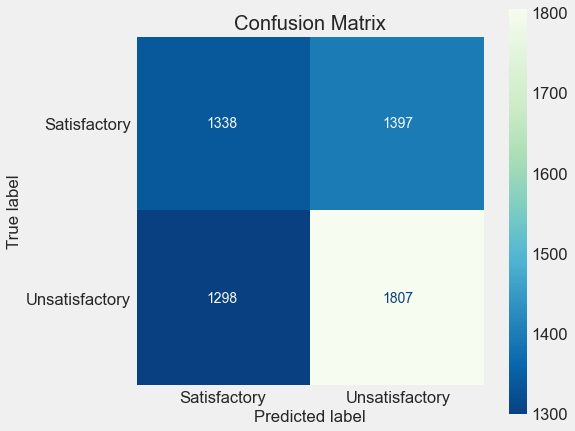

,Accuracy,F1,Recall,Precision
0,0.538527,0.572832,0.581965,0.563983


time: 19.4 s


In [37]:
f.confusion_report(knn, X_test, y_test)

## Logistic Regression Classifier

In [38]:
LR = LogisticRegression(max_iter=1000, n_jobs=-1, random_state = 2021, verbose=0)

time: 908 µs


In [39]:
logreg = make_pipeline(preprocessing_ohe, LR)

time: 938 µs


### Fitting Model

In [40]:
logreg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1029b55b0>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1,
                                    random_state=2021))])

time: 4.35 s


In [41]:
# f.pickle_model(logreg, 'logreg')

time: 695 µs


### Cross Val Scores

In [42]:
# checking cross val scores
modeling.report(logreg, X_train, y_train, 'logreg', 'Logistic Regression')

logreg has an average Accuracy of 0.5881378420584051
logreg has an average F1 of 0.6347719400680819
logreg has an average Recall of 0.6731078904991948
logreg has an average Precision of 0.6006268985152368


[0.5881378420584051,
 0.6347719400680819,
 0.6731078904991948,
 0.6006268985152368]

time: 2.23 s


### Test Data Confusion Matrix

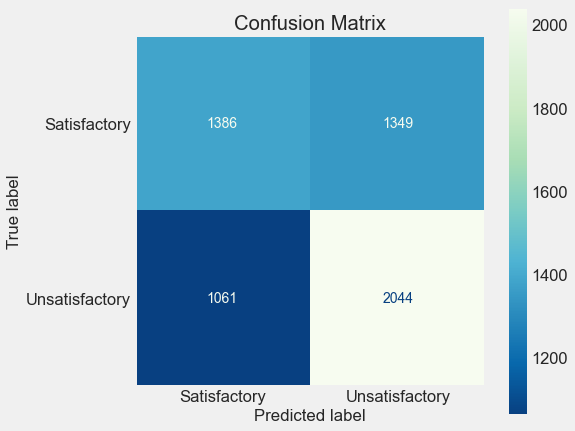

,Accuracy,F1,Recall,Precision
0,0.587329,0.629117,0.658293,0.602417


time: 235 ms


In [43]:
f.confusion_report(logreg, X_test, y_test)

## Support Vector Machine

In [44]:
SVC = SVC()

time: 883 µs


In [45]:
svc = make_pipeline(preprocessing_ohe, SVC)

time: 1.26 ms


### Fitting Model

In [46]:
svc.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1029b55b0>)])),
                ('svc', SVC())])

time: 15.7 s


In [47]:
# f.pickle_model(svc, 'svc')

time: 613 µs


### Cross Val Scores

In [48]:
# checking cross val scores
modeling.report(svc, X_train, y_train, 'svc', 'Support Vector Classifier')

svc has an average Accuracy of 0.5862538404785461
svc has an average F1 of 0.6333514871177801
svc has an average Recall of 0.6722490606548578
svc has an average Precision of 0.598869767995082


[0.5862538404785461, 0.6333514871177801, 0.6722490606548578, 0.598869767995082]

time: 58.7 s


### Test Data Confusion Matrix

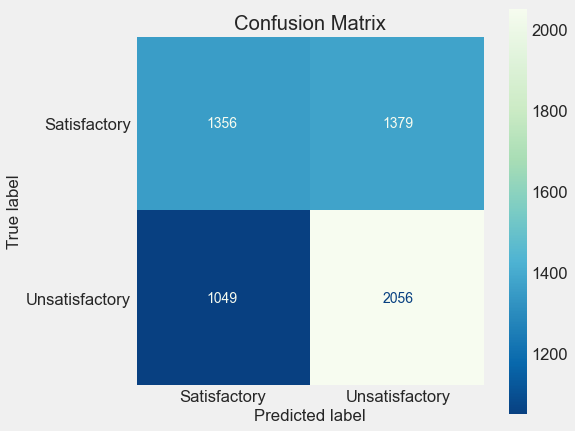

,Accuracy,F1,Recall,Precision
0,0.584247,0.628746,0.662158,0.598544


time: 17.8 s


In [49]:
f.confusion_report(svc, X_test, y_test)

## Linear Support Vector Machine

In [50]:
LSVC = LinearSVC()

time: 785 µs


In [51]:
lsvc = make_pipeline(preprocessing_ohe, LSVC)

time: 918 µs


### Fitting Model

In [52]:
lsvc.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1029b55b0>)])),
                ('linearsvc', LinearSVC())])

time: 242 ms


In [53]:
# f.pickle_model(lsvc, 'lsvc')

time: 683 µs


### Cross Val Scores

In [54]:
# checking cross val scores
modeling.report(lsvc, X_train, y_train, 'lsvc', 'Linear SVC')

lsvc has an average Accuracy of 0.5879095641439758
lsvc has an average F1 of 0.6342005253547821
lsvc has an average Recall of 0.6718196457326892
lsvc has an average Precision of 0.6006246607968653


[0.5879095641439758,
 0.6342005253547821,
 0.6718196457326892,
 0.6006246607968653]

time: 901 ms


### Test Data Confusion Matrix

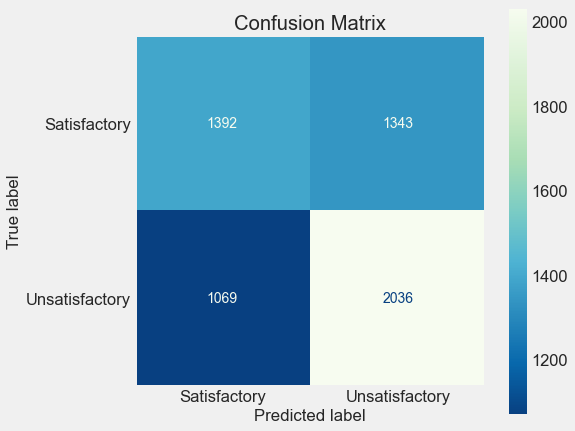

,Accuracy,F1,Recall,Precision
0,0.586986,0.628007,0.655717,0.602545


time: 241 ms


In [55]:
f.confusion_report(lsvc, X_test, y_test)

## Decision Tree

In [56]:
DT = DecisionTreeClassifier(random_state=2021)

time: 810 µs


In [57]:
dt = make_pipeline(preprocessing_ohe, DT)

time: 1.23 ms


### Fitting Model

In [58]:
dt.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1029b55b0>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=2021))])

time: 242 ms


In [59]:
# f.pickle_model(dt, 'dt')

time: 677 µs


### Cross Val Scores

In [60]:
# checking cross val scores
modeling.report(dt, X_train, y_train, 'dt', 'Decision Tree')

dt has an average Accuracy of 0.5532018706731479
dt has an average F1 of 0.5748150762120996
dt has an average Recall of 0.5682232957595277
dt has an average Precision of 0.5817330458653753


[0.5532018706731479,
 0.5748150762120996,
 0.5682232957595277,
 0.5817330458653753]

time: 950 ms


### Test Data Confusion Matrix

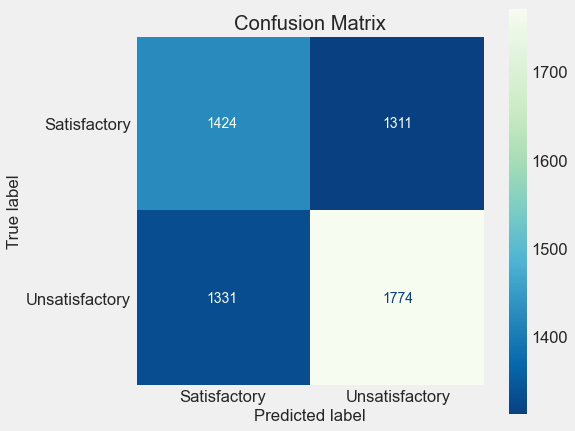

,Accuracy,F1,Recall,Precision
0,0.547603,0.573183,0.571337,0.575041


time: 241 ms


In [61]:
f.confusion_report(dt, X_test, y_test)

## Bagging Classifier

In [62]:
BCLF = BaggingClassifier(base_estimator=DT, random_state=2021)

time: 936 µs


In [63]:
bclf = make_pipeline(preprocessing_ohe, BCLF)

time: 1.03 ms


### Fitting Model

In [64]:
bclf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1029b55b0>)])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                   random_state=2021))])

time: 1.42 s


In [65]:
# f.pickle_model(bclf, 'bclf')

time: 657 µs


### Cross Val Scores

In [66]:
# checking cross val scores
modeling.report(bclf, X_train, y_train, 'bclf', 'Bagging CLF')

bclf has an average Accuracy of 0.5532024735484391
bclf has an average F1 of 0.5988541080007854
bclf has an average Recall of 0.6273752012882448
bclf has an average Precision of 0.5729585359794639


[0.5532024735484391,
 0.5988541080007854,
 0.6273752012882448,
 0.5729585359794639]

time: 5.45 s


### Test Data Confusion Matrix

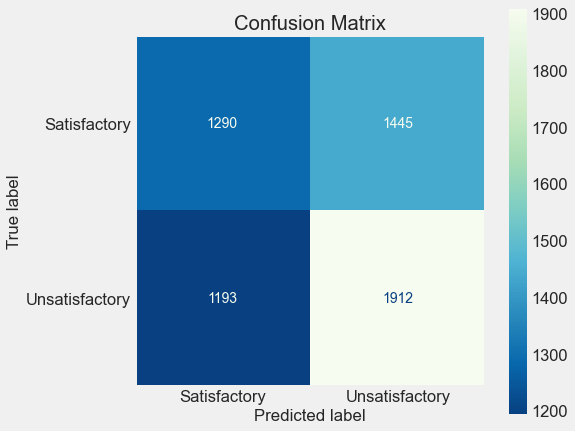

,Accuracy,F1,Recall,Precision
0,0.548288,0.591767,0.615781,0.569556


time: 306 ms


In [67]:
f.confusion_report(bclf, X_test, y_test)

## Random Forest Classifier

In [68]:
RF = RandomForestClassifier(n_jobs=-1, random_state=2021)

time: 889 µs


In [69]:
rf = make_pipeline(preprocessing_ohe, RF)

time: 1.15 ms


### Fitting Model

In [70]:
rf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1029b55b0>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2021))])

time: 2.3 s


In [71]:
# f.pickle_model(rf, 'rf')

time: 673 µs


### Cross Val Scores

In [72]:
# checking cross val scores
modeling.report(rf, X_train, y_train, 'rf', 'Random Forest')

rf has an average Accuracy of 0.5553142479309973
rf has an average F1 of 0.6003924318643543
rf has an average Recall of 0.628341384863124
rf has an average Precision of 0.5748867257588556


[0.5553142479309973, 0.6003924318643543, 0.628341384863124, 0.5748867257588556]

time: 11.7 s


### Test Data Confusion Matrix

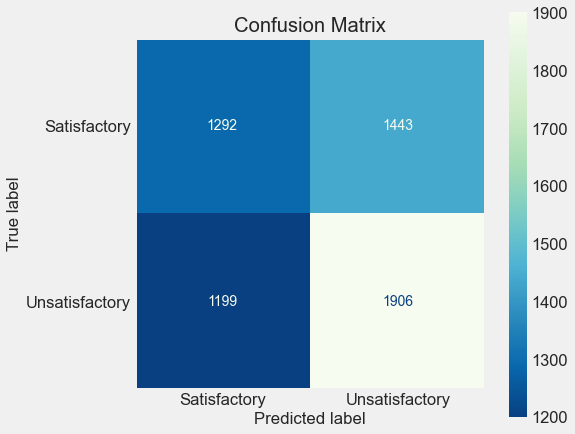

,Accuracy,F1,Recall,Precision
0,0.547603,0.590641,0.613849,0.569125


time: 611 ms


In [73]:
f.confusion_report(rf, X_test, y_test)

## AdaBoost

In [74]:
ADA = AdaBoostClassifier(base_estimator=DT, random_state=2021)

time: 960 µs


In [75]:
ada = make_pipeline(preprocessing_ohe, ADA)

time: 1.12 ms


### Fitting Model

In [76]:
ada.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1029b55b0>)])),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                    random_state=2021))])

time: 1.19 s


In [77]:
# f.pickle_model(ada, 'ada')

time: 681 µs


### Cross Val Scores

In [78]:
# checking cross val scores
modeling.report(ada, X_train, y_train, 'ada', 'AdaBoost')

ada has an average Accuracy of 0.5548578387474793
ada has an average F1 of 0.6052569163848175
ada has an average Recall of 0.6420826623725173
ada has an average Precision of 0.572620544267312


[0.5548578387474793, 0.6052569163848175, 0.6420826623725173, 0.572620544267312]

time: 4.7 s


### Test Data Confusion Matrix

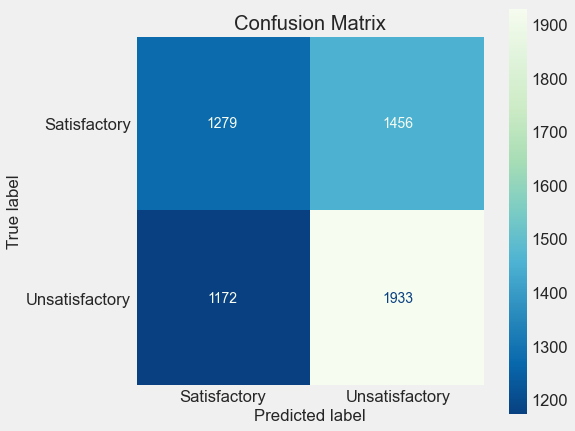

,Accuracy,F1,Recall,Precision
0,0.55,0.595319,0.622544,0.570375


time: 445 ms


In [79]:
f.confusion_report(ada, X_test, y_test)

## XGBoost

In [80]:
XGB = XGBClassifier(use_label_encoder=False)

time: 814 µs


In [81]:
xgb = make_pipeline(preprocessing_ohe, XGB)

time: 918 µs


### Fitting Model

In [82]:
%%capture --no-display
xgb.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1029b55b0>)])),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               impo...pe='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1, random_state=0,
            

time: 605 ms


In [83]:
# f.pickle_model(xgb, 'xgb')

time: 872 µs


### Cross Val Scores

In [84]:
%%capture --no-display
# checking cross val scores
modeling.report(xgb, X_train, y_train, 'xgb', 'XGBoost')

[0.5623928185495277,
 0.6070381993236268,
 0.6359634997316157,
 0.5808108916927115]

time: 2.7 s


### Test Data Confusion Matrix

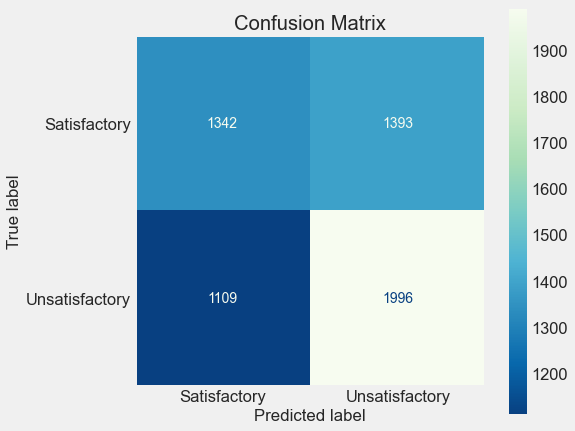

,Accuracy,F1,Recall,Precision
0,0.571575,0.614721,0.642834,0.588964


time: 379 ms


In [85]:
%%capture --no-display
f.confusion_report(xgb, X_test, y_test)

## Model Summary 1

In [86]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,dt,0.553202,0.574815,0.568223,0.581733,0.945038,Decision Tree
1,knn,0.547380,0.578151,0.583360,0.573258,9.082440,KNN
2,bclf,0.553202,0.598854,0.627375,0.572959,5.447410,Bagging CLF
3,rf,0.555314,0.600392,0.628341,0.574887,11.738072,Random Forest
10,xgb,0.562393,0.607038,0.635963,0.580811,2.689889,XGBoost
4,ada,0.554858,0.605257,0.642083,0.572621,4.695330,AdaBoost
5,fsm,0.585397,0.630474,0.665164,0.599282,0.299676,FSM Naive Bayes
6,lsvc,0.587910,0.634201,0.671820,0.600625,0.896083,Linear SVC
7,svc,0.586254,0.633351,0.672249,0.598870,58.694316,Support Vector Classifier
8,logreg,0.588138,0.634772,0.673108,0.600627,2.224927,Logistic Regression


time: 11.8 ms


# Adding STUDENTVLE Features
<font size=4>(click_sum, num_activities)</font>

In [87]:
df = db.student_info_vle_full()

time: 32.1 s


In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29228 entries, 0 to 29227
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   target                29228 non-null  int64 
 1   row_id                29228 non-null  object
 2   code_module           29228 non-null  object
 3   code_presentation     29228 non-null  object
 4   id_student            29228 non-null  object
 5   id_site               29228 non-null  object
 6   date                  29228 non-null  object
 7   sum_click             29228 non-null  object
 8   code_module           29228 non-null  object
 9   code_presentation     29228 non-null  object
 10  id_student            29228 non-null  object
 11  gender                29228 non-null  object
 12  region                29228 non-null  object
 13  highest_education     29228 non-null  object
 14  imd_band              28174 non-null  object
 15  age_band              29228 non-null

In [89]:
drops = ['row_id', 'code_module', 'code_presentation', 'studied_credits',
         'id_student', 'id_site', 'date', 'sum_click', 'final_result']

df = db.pipe_cleaner(df, drops)

time: 106 ms


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26470 entries, 0 to 29227
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   target                26470 non-null  int64 
 1   gender                26470 non-null  object
 2   region                26470 non-null  object
 3   highest_education     26470 non-null  object
 4   imd_band              26470 non-null  object
 5   age_band              26470 non-null  object
 6   num_of_prev_attempts  26470 non-null  int64 
 7   disability            26470 non-null  object
 8   click_sum             26470 non-null  int64 
 9   num_activities        26470 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 2.2+ MB
time: 14.8 ms


In [91]:
df.head()

,target,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,disability,click_sum,num_activities
0,0,Male,Yorkshire Region,A Level or Equivalent,20-30%,0-35,0,No,744,243
1,0,Male,South Region,Lower Than A Level,80-90%,35-55,0,No,4104,913
2,0,Male,North Western Region,A Level or Equivalent,30-40%,0-35,0,No,1944,781
3,0,Male,London Region,HE Qualification,60-70%,0-35,0,No,1150,313
4,0,Female,London Region,Lower Than A Level,30-40%,35-55,0,No,1896,572


time: 8.82 ms


In [92]:
df.describe()

,target,num_of_prev_attempts,click_sum,num_activities
count,26470.000000,26470.000000,26470.000000,26470.000000
mean,0.469890,0.144125,1338.822629,360.084133
std,0.499102,0.452979,1719.149524,375.345601
min,0.000000,0.000000,1.000000,1.000000
25%,0.000000,0.000000,259.000000,93.000000
50%,0.000000,0.000000,731.500000,239.000000
75%,1.000000,0.000000,1740.000000,500.000000
max,1.000000,6.000000,24139.000000,2953.000000


time: 22.9 ms


## Creating Holdout Data

In [93]:
# splitting data & target
X, y = f.X_y(df)

time: 4.95 ms


In [94]:
# splitting traing and holdout data
X_training, X_holdout, y_training, y_holdout = f.test_train(X, y)

time: 15.3 ms


## Creating Training Data

In [95]:
# train test split
X_train, X_test, y_train, y_test = f.test_train(X_training, y_training)

time: 13.1 ms


## MinMax Scaling
Since we've added numerical columns with very different scales to the data, we'll implement some scaling in the pipeline. K-Nearest Neighbors in particular is sensitive to differences in feature scale, and scaling can also help speed up convergence is certain algorithms.

## Naive Bayes Classifier

In [96]:
mnb_svsi = make_pipeline(preprocessing_mm, mnb)

time: 866 µs


### Fitting Model

In [97]:
mnb_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1029b55b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10dd1dfa0>)])),
                ('multinomialnb', MultinomialNB())])

time: 71 ms


### Saving Model

In [98]:
# f.pickle_model(mnb_svsi, 'mnb_svsi')

time: 767 µs


### Cross Val Scores

In [99]:
# checking cross val scores
modeling.report(mnb_svsi, X_train, y_train, ' mnb_svsi',\
                'Naive Bayes SVSI/MinMax()')

 mnb_svsi has an average Accuracy of 0.6511515529965238
 mnb_svsi has an average F1 of 0.6004921499760085
 mnb_svsi has an average Recall of 0.5580313489226999
 mnb_svsi has an average Precision of 0.6499920377587581


[0.6511515529965238,
 0.6004921499760085,
 0.5580313489226999,
 0.6499920377587581]

time: 355 ms


### Test Data Confusion Matrix

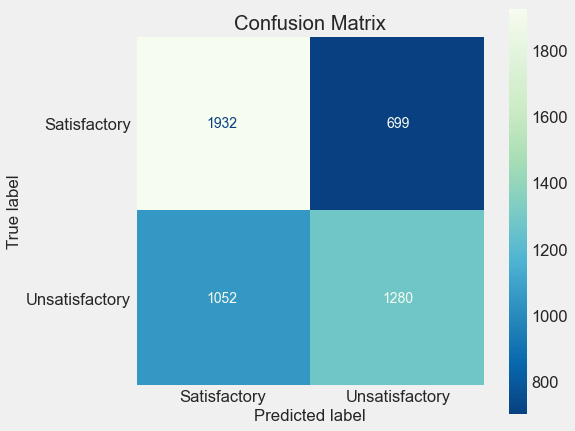

,Accuracy,F1,Recall,Precision
0,0.647189,0.59383,0.548885,0.646791


time: 282 ms


In [100]:
f.confusion_report(mnb_svsi, X_test, y_test)

## KNeighborsClassifier

In [101]:
knn_svsi = make_pipeline(preprocessing_mm, KNN)

time: 1.04 ms


### Fitting Model

In [102]:
knn_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1029b55b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10dd1dfa0>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1))])

time: 64.1 ms


In [103]:
# f.pickle_model(knn_svsi, 'knn_svsi')

time: 687 µs


### Cross Val Scores

In [104]:
# checking cross val scores
modeling.report(knn_svsi, X_train, y_train, 'knn_svsi',\
                'KNN SVSI/MinMax()')

knn_svsi has an average Accuracy of 0.6838607745570304
knn_svsi has an average F1 of 0.6586426638627266
knn_svsi has an average Recall of 0.6490860818952313
knn_svsi has an average Precision of 0.6684974392837131


[0.6838607745570304,
 0.6586426638627266,
 0.6490860818952313,
 0.6684974392837131]

time: 7.16 s


### Test Data Confusion Matrix

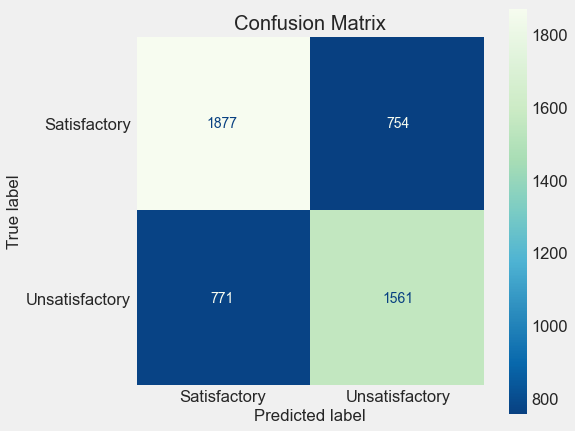

,Accuracy,F1,Recall,Precision
0,0.692726,0.671831,0.669383,0.674298


time: 15 s


In [105]:
f.confusion_report(knn_svsi, X_test, y_test)

## Logistic Regression Classifier

In [106]:
logreg_svsi = make_pipeline(preprocessing_mm, LR)

time: 968 µs


### Fitting Model

In [107]:
logreg_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1029b55b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10dd1dfa0>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1,
                                    random_state=2021))])

time: 246 ms


In [108]:
# f.pickle_model(logreg_svsi, 'logreg_svsi')

time: 733 µs


### Cross Val Scores

In [109]:
# checking cross val scores
modeling.report(logreg_svsi, X_train, y_train, 'logreg_svsi',\
                'LogReg SVSI/MinMax()')

logreg_svsi has an average Accuracy of 0.7752698153946318
logreg_svsi has an average F1 of 0.7713370572078657
logreg_svsi has an average Recall of 0.806604002859185
logreg_svsi has an average Precision of 0.7391091970077099


[0.7752698153946318, 0.7713370572078657, 0.806604002859185, 0.7391091970077099]

time: 900 ms


### Test Data Confusion Matrix

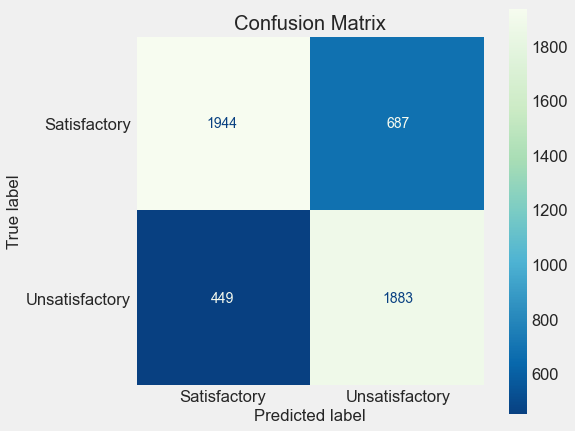

,Accuracy,F1,Recall,Precision
0,0.771106,0.768258,0.807461,0.732685


time: 264 ms


In [110]:
f.confusion_report(logreg_svsi, X_test, y_test)

## Support Vector Machine

In [111]:
svc_svsi = make_pipeline(preprocessing_mm, SVC)

time: 886 µs


### Fitting Model

In [112]:
svc_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1029b55b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10dd1dfa0>)])),
                ('svc', SVC())])

time: 10.1 s


In [113]:
# f.pickle_model(svc, 'svc_svsi')

time: 657 µs


### Cross Val Scores

In [114]:
# checking cross val scores
modeling.report(svc_svsi, X_train, y_train, 'svc_svsi',\
                'Support Vector CLF SVSI/MinMax()')

svc_svsi has an average Accuracy of 0.7586804182412148
svc_svsi has an average F1 of 0.755314293594922
svc_svsi has an average Recall of 0.7925952210762789
svc_svsi has an average Precision of 0.7214731939685197


[0.7586804182412148, 0.755314293594922, 0.7925952210762789, 0.7214731939685197]

time: 37.8 s


### Test Data Confusion Matrix

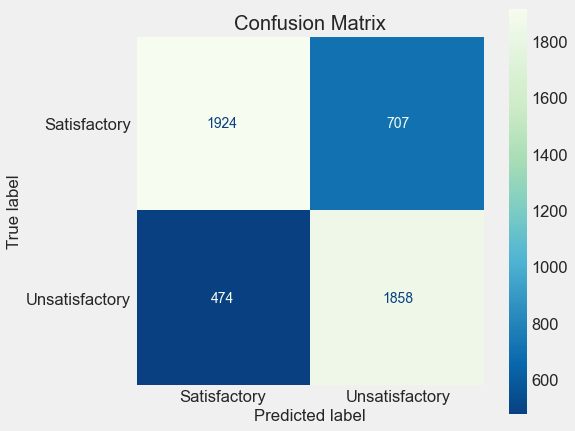

,Accuracy,F1,Recall,Precision
0,0.762039,0.758832,0.796741,0.724366


time: 11.6 s


In [115]:
f.confusion_report(svc_svsi, X_test, y_test)

## Linear Support Vector Machine

In [116]:
lsvc_svsi = make_pipeline(preprocessing_mm, LSVC)

time: 1.11 ms


### Fitting Model

In [117]:
lsvc_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1029b55b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10dd1dfa0>)])),
                ('linearsvc', LinearSVC())])

time: 206 ms


In [118]:
# f.pickle_model(lsvc_svsi, 'lsvc_svsi')

time: 1.06 ms


### Cross Val Scores

In [119]:
# checking cross val scores
modeling.report(lsvc_svsi, X_train, y_train, 'lsvc_svsi',\
                'Linear SVC SVSI/MinMax()')

lsvc_svsi has an average Accuracy of 0.7711732641092341
lsvc_svsi has an average F1 of 0.7707348320961438
lsvc_svsi has an average Recall of 0.818611048708261
lsvc_svsi has an average Precision of 0.728228844792579


[0.7711732641092341, 0.7707348320961438, 0.818611048708261, 0.728228844792579]

time: 847 ms


### Test Data Confusion Matrix

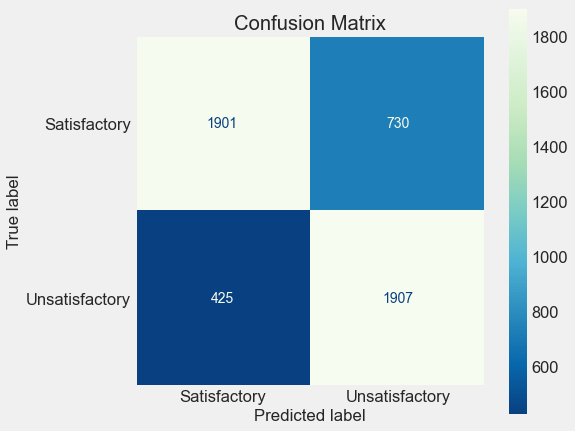

,Accuracy,F1,Recall,Precision
0,0.767278,0.767559,0.817753,0.72317


time: 273 ms


In [120]:
f.confusion_report(lsvc_svsi, X_test, y_test)

## Decision Tree

In [121]:
dt_svsi = make_pipeline(preprocessing_mm, DT)

time: 954 µs


### Fitting Model

In [122]:
dt_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1029b55b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10dd1dfa0>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=2021))])

time: 526 ms


In [123]:
# f.pickle_model(dt_svsi, 'dt_svsi')

time: 742 µs


### Cross Val Scores

In [124]:
# checking cross val scores
modeling.report(dt_svsi, X_train, y_train, 'dt_svsi',\
                'Decision Tree CLF SVSI/MinMax()')

dt_svsi has an average Accuracy of 0.713815725802904
dt_svsi has an average F1 of 0.6972835816297781
dt_svsi has an average Recall of 0.7015451853364648
dt_svsi has an average Precision of 0.6931909683478993


[0.713815725802904, 0.6972835816297781, 0.7015451853364648, 0.6931909683478993]

time: 2 s


### Test Data Confusion Matrix

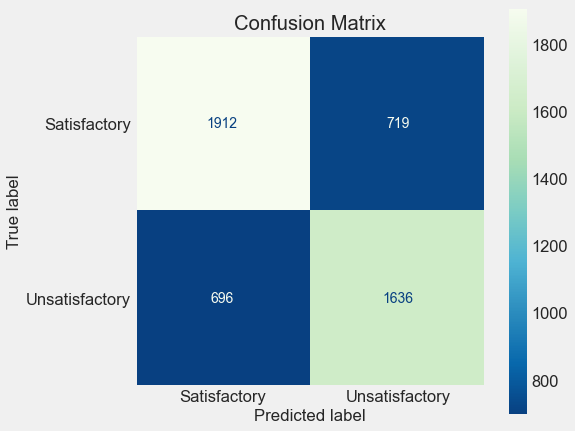

,Accuracy,F1,Recall,Precision
0,0.71489,0.698101,0.701544,0.694692


time: 275 ms


In [125]:
f.confusion_report(dt_svsi, X_test, y_test)

## Bagging Classifier

In [126]:
bclf_svsi = make_pipeline(preprocessing_mm, BCLF)

time: 1.22 ms


### Fitting Model

In [127]:
bclf_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1029b55b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10dd1dfa0>)])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                   random_state=2021))])

time: 3.12 s


In [128]:
# f.pickle_model(bclf_svsi, 'bclf_svsi')

time: 715 µs


### Cross Val Scores

In [129]:
# checking cross val scores
modeling.report(bclf_svsi, X_train, y_train, 'bclf_svsi',\
                'Bagging CLF SVSI/MinMax()')

bclf_svsi has an average Accuracy of 0.7640543472645553
bclf_svsi has an average F1 of 0.7292893009821926
bclf_svsi has an average Recall of 0.6765289492494639
bclf_svsi has an average Precision of 0.791078275378512


[0.7640543472645553, 0.7292893009821926, 0.6765289492494639, 0.791078275378512]

time: 11.9 s


### Test Data Confusion Matrix

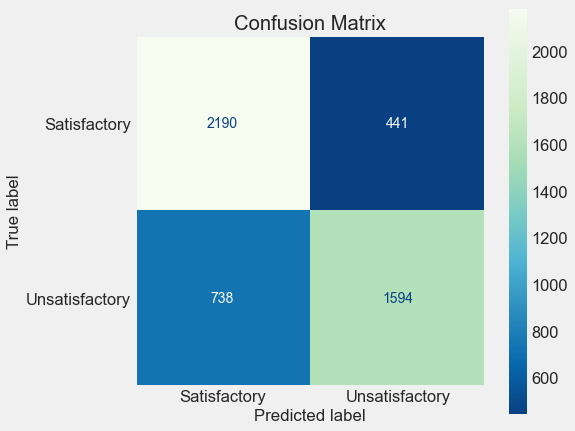

,Accuracy,F1,Recall,Precision
0,0.762442,0.730021,0.683533,0.783292


time: 339 ms


In [130]:
f.confusion_report(bclf_svsi, X_test, y_test)

## Random Forest Classifier

In [131]:
rf_svsi = make_pipeline(preprocessing_mm, RF)

time: 1.02 ms


### Fitting Model

In [132]:
rf_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1029b55b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10dd1dfa0>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2021))])

time: 2.94 s


In [133]:
# f.pickle_model(rf_svsi, 'rf_svsi')

time: 709 µs


### Cross Val Scores

In [134]:
# checking cross val scores
modeling.report(rf_svsi, X_train, y_train, 'rf_svsi',\
                'Random Forest SVSI/MinMax()')

rf_svsi has an average Accuracy of 0.7768826054598575
rf_svsi has an average F1 of 0.7498473690552829
rf_svsi has an average Recall of 0.7118373327887266
rf_svsi has an average Precision of 0.792230079562219


[0.7768826054598575, 0.7498473690552829, 0.7118373327887266, 0.792230079562219]

time: 12.7 s


### Test Data Confusion Matrix

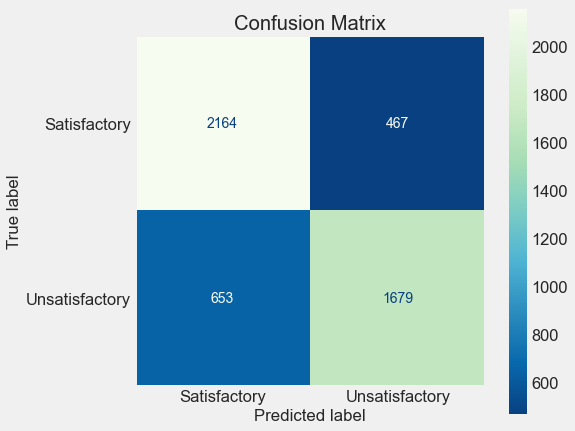

,Accuracy,F1,Recall,Precision
0,0.77433,0.749888,0.719983,0.782386


time: 604 ms


In [135]:
f.confusion_report(rf_svsi, X_test, y_test)

## AdaBoost

In [136]:
ada_svsi = make_pipeline(preprocessing_mm, ADA)

time: 1.06 ms


### Fitting Model

In [137]:
ada_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1029b55b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10dd1dfa0>)])),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                    random_state=2021))])

time: 552 ms


In [138]:
# f.pickle_model(ada_svsi, 'ada_svsi')

time: 939 µs


### Cross Val Scores

In [139]:
# checking cross val scores
modeling.report(ada_svsi, X_train, y_train, 'ada_svsi',\
                'AdaBoost SVSI/MinMax()')

ada_svsi has an average Accuracy of 0.7134796366952998
ada_svsi has an average F1 of 0.696720016390799
ada_svsi has an average Recall of 0.7005452874502195
ada_svsi has an average Precision of 0.6930858638492422


[0.7134796366952998, 0.696720016390799, 0.7005452874502195, 0.6930858638492422]

time: 2.22 s


### Test Data Confusion Matrix

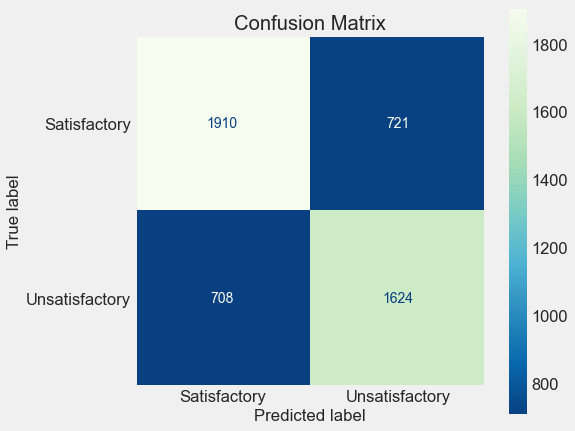

,Accuracy,F1,Recall,Precision
0,0.712069,0.694462,0.696398,0.692537


time: 267 ms


In [140]:
f.confusion_report(ada_svsi, X_test, y_test)

## XGBoost

In [141]:
xgb_svsi = make_pipeline(preprocessing_mm, XGB)

time: 1.14 ms


### Fitting Model

In [142]:
%%capture --no-display
xgb_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1029b55b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10dd1dfa0>)])),
                ('xgbclassifier',
                 XGBClassifier(ba...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estima

time: 1.72 s


In [143]:
# f.pickle_model(xgb_svsi, 'xgb_svsi')

time: 831 µs


### Cross Val Scores

In [144]:
%%capture --no-display
# checking cross val scores
modeling.report(xgb_svsi, X_train, y_train, 'xgb_svsi',\
                'XGBoost SVSI/MinMax()')

[0.7804414322205636,
 0.7525015005622014,
 0.7102636577146941,
 0.8001568893894099]

time: 7.42 s


### Test Data Confusion Matrix

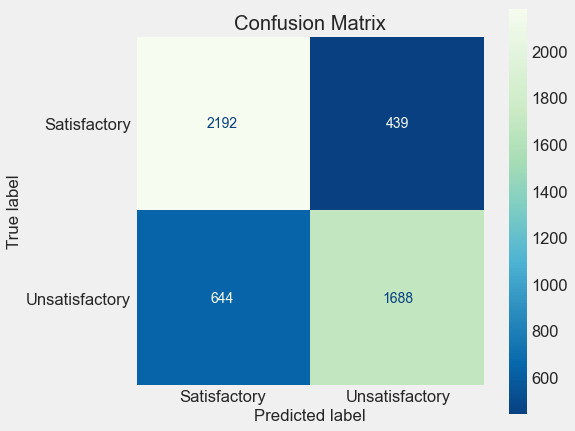

,Accuracy,F1,Recall,Precision
0,0.781785,0.75712,0.723842,0.793606


time: 454 ms


In [145]:
%%capture --no-display
f.confusion_report(xgb_svsi, X_test, y_test)

## Model Summary 2

In [146]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,mnb_svsi,0.651152,0.600492,0.558031,0.649992,0.350796,Naive Bayes SVSI/MinMax()
1,dt,0.553202,0.574815,0.568223,0.581733,0.945038,Decision Tree
2,knn,0.547380,0.578151,0.583360,0.573258,9.082440,KNN
3,bclf,0.553202,0.598854,0.627375,0.572959,5.447410,Bagging CLF
4,rf,0.555314,0.600392,0.628341,0.574887,11.738072,Random Forest
5,xgb,0.562393,0.607038,0.635963,0.580811,2.689889,XGBoost
6,ada,0.554858,0.605257,0.642083,0.572621,4.695330,AdaBoost
7,knn_svsi,0.683861,0.658643,0.649086,0.668497,7.159089,KNN SVSI/MinMax()
8,fsm,0.585397,0.630474,0.665164,0.599282,0.299676,FSM Naive Bayes
9,lsvc,0.587910,0.634201,0.671820,0.600625,0.896083,Linear SVC


time: 12.1 ms


## Voting Classifier
Using the top three model in a voting classifier.

In [147]:
clf1 = LR
clf2 = SVC
clf3 = XGB

estimators = [('logreg', clf1), ('scv', clf2), ('lsvc',clf3)]

VC = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1)

time: 1.21 ms


In [148]:
vc_svsi = make_pipeline(preprocessing_mm, VC)

time: 1.08 ms


### Fitting Model

In [149]:
%%capture --no-display
vc_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1029b55b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10dd1dfa0>)])),
                ('votingclassifier',
                 VotingClassif...
                                                             interaction_constraints='',
                                                             learning_rate=0.300000012,
                                                             max_delta_step=0,
                                                             max_depth=6,
   

time: 12.7 s


In [150]:
# f.pickle_model(vc_svsi, 'vc_svsi')

time: 862 µs


### Cross Val Scores

In [151]:
%%capture --no-display
# checking cross val scores
modeling.report(vc_svsi, X_train, y_train, 'vc_svsi',\
                'Voting CLF SVSI/MinMax()')

[0.7786279993493885, 0.769956071630871, 0.7883076687429798, 0.7525339045876993]

time: 48 s


### Test Data Confusion Matrix

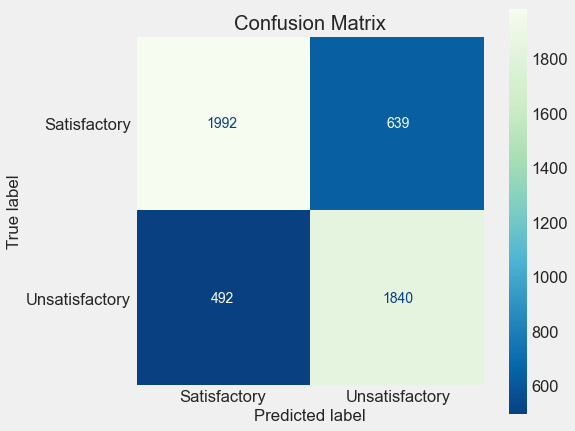

,Accuracy,F1,Recall,Precision
0,0.772114,0.764914,0.789022,0.742235


time: 12.9 s


In [152]:
%%capture --no-display
f.confusion_report(vc_svsi, X_test, y_test)

## Model Summary 3

In [153]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,mnb_svsi,0.651152,0.600492,0.558031,0.649992,0.350796,Naive Bayes SVSI/MinMax()
1,dt,0.553202,0.574815,0.568223,0.581733,0.945038,Decision Tree
2,knn,0.547380,0.578151,0.583360,0.573258,9.082440,KNN
3,bclf,0.553202,0.598854,0.627375,0.572959,5.447410,Bagging CLF
4,rf,0.555314,0.600392,0.628341,0.574887,11.738072,Random Forest
5,xgb,0.562393,0.607038,0.635963,0.580811,2.689889,XGBoost
6,ada,0.554858,0.605257,0.642083,0.572621,4.695330,AdaBoost
7,knn_svsi,0.683861,0.658643,0.649086,0.668497,7.159089,KNN SVSI/MinMax()
8,fsm,0.585397,0.630474,0.665164,0.599282,0.299676,FSM Naive Bayes
9,lsvc,0.587910,0.634201,0.671820,0.600625,0.896083,Linear SVC


time: 14.2 ms


## Neural Network

### Create Model

In [154]:
def create_model():
    # building model
    model = Sequential()
    model.add(Dense(64, input_dim=38, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    return model

time: 1.37 ms


In [155]:
NN = KerasClassifier(build_fn=create_model,
                     epochs=10,
                     batch_size=32,
                     verbose=0)

time: 2.02 ms


### Pipeline

In [156]:
nn_svsi = make_pipeline(preprocessing_mm, NN)

time: 971 µs


### Fitting Models

In [157]:
# %%capture --no-display
nn_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1029b55b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10dd1dfa0>)])),
                ('kerasclassifier',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x1c81ee070>)])

time: 6.77 s


In [158]:
# f.pickle_model(nn_svsi, 'nn_svsi')

time: 954 µs


### Cross Val Scores

In [159]:
%%capture --no-display
modeling.report(nn_svsi, X_train, y_train, 'nn_svsi',\
                'Neural Net SVSI/MinMax()')

[0.7882999120411176, 0.7634409396811179, 0.7279331717580201, 0.804405883088398]

time: 27.6 s


### Test Data Confusion Matrix

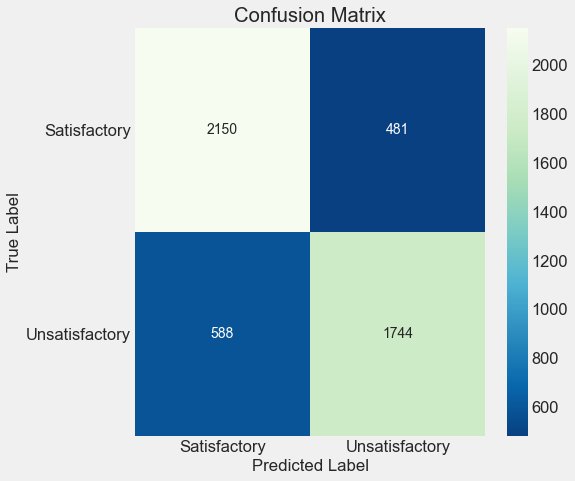

,Accuracy,F1,Recall,Precision
0,0.784606,0.765416,0.747856,0.78382


time: 832 ms


In [160]:
%%capture --no-display
f.confusion_report_nn(nn_svsi, X_test, y_test)

## Model Summary 4

In [161]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,mnb_svsi,0.651152,0.600492,0.558031,0.649992,0.350796,Naive Bayes SVSI/MinMax()
1,dt,0.553202,0.574815,0.568223,0.581733,0.945038,Decision Tree
2,knn,0.547380,0.578151,0.583360,0.573258,9.082440,KNN
3,bclf,0.553202,0.598854,0.627375,0.572959,5.447410,Bagging CLF
4,rf,0.555314,0.600392,0.628341,0.574887,11.738072,Random Forest
5,xgb,0.562393,0.607038,0.635963,0.580811,2.689889,XGBoost
6,ada,0.554858,0.605257,0.642083,0.572621,4.695330,AdaBoost
7,knn_svsi,0.683861,0.658643,0.649086,0.668497,7.159089,KNN SVSI/MinMax()
8,fsm,0.585397,0.630474,0.665164,0.599282,0.299676,FSM Naive Bayes
9,lsvc,0.587910,0.634201,0.671820,0.600625,0.896083,Linear SVC


time: 14.6 ms


In [162]:
%%capture --no-display
# df = modeling.history
# f.df_plot(df, 'modeling_history')

time: 1.01 ms


# Adding Assessment Data Features
<font size=4>(mean_score, median_score, weighted_ave)</font>

In [163]:
df = db.data_prep_full()

time: 20.2 s


In [164]:
# path = os.path.join(gparent, 'data/processed/df2.csv')
# df = pd.read_csv(path)

time: 872 µs


In [165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26331 entries, 0 to 26330
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   target                26331 non-null  int64  
 1   row_id                26331 non-null  object 
 2   gender                26331 non-null  object 
 3   region                26331 non-null  object 
 4   highest_education     26331 non-null  object 
 5   imd_band              25326 non-null  object 
 6   age_band              26331 non-null  object 
 7   num_of_prev_attempts  26331 non-null  int64  
 8   studied_credits       26331 non-null  int64  
 9   disability            26331 non-null  object 
 10  final_result          26331 non-null  object 
 11  date_sub              26331 non-null  int64  
 12  course_length         26331 non-null  int64  
 13  weighted_ave          26312 non-null  float64
 14  mean_score            26312 non-null  float64
 15  median_score       

In [166]:
df.weighted_ave.describe()

count    26312.000000
mean       251.356656
std        216.520394
min          0.000000
25%         76.175000
50%        240.000000
75%        336.835000
max       1908.760000
Name: weighted_ave, dtype: float64

time: 6.76 ms


In [167]:
# df = db.df_a()

time: 807 µs


In [168]:
drops = ['row_id', 'sum_click', 'date', 'max_date', 'date_sub',
         'course_length','id_site', 'studied_credits', 'final_result']

time: 968 µs


In [169]:
# %%capture --no-display
df = db.pipe_cleaner_wa(df, drops)

time: 70.1 ms


In [170]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23182 entries, 0 to 26330
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   target                23182 non-null  int64   
 1   gender                23182 non-null  object  
 2   region                23182 non-null  object  
 3   highest_education     23182 non-null  object  
 4   imd_band              23182 non-null  object  
 5   age_band              23182 non-null  object  
 6   num_of_prev_attempts  23182 non-null  int64   
 7   disability            23182 non-null  object  
 8   weighted_ave          23182 non-null  float64 
 9   mean_score            23182 non-null  float64 
 10  median_score          23182 non-null  float64 
 11  sum_activity          23182 non-null  int64   
 12  course_load           23182 non-null  category
dtypes: category(1), float64(3), int64(3), object(6)
memory usage: 2.3+ MB
time: 19.8 ms


In [171]:
df.weighted_ave.describe()

count    23182.000000
mean       227.435603
std        173.028329
min          0.000000
25%         70.400000
50%        232.680000
75%        327.000000
max        730.000000
Name: weighted_ave, dtype: float64

time: 7.82 ms


## Creating Holdout Data

In [172]:
# splitting data & target
X, y = f.X_y(df)

time: 4.8 ms


In [173]:
# splitting traing and holdout data
X_training, X_holdout, y_training, y_holdout = f.test_train(X, y)

time: 16.5 ms


## Creating Training Data

In [174]:
# train test split
X_train, X_test, y_train, y_test = f.test_train(X_training, y_training)

time: 11.3 ms


## Naive Bayes Classifier

In [175]:
mnb_assess = make_pipeline(preprocessing_mm, mnb)

time: 1.09 ms


### Fitting Model

In [176]:
mnb_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1029b55b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10dd1dfa0>)])),
                ('multinomialnb', MultinomialNB())])

time: 65.6 ms


### Saving Model

In [177]:
# f.pickle_model(mnb_assess, 'mnb_assess')

time: 1.28 ms


### Cross Val Scores

In [178]:
# checking cross val scores
modeling.report(mnb_assess, X_train, y_train, 'mnb_assess',\
                'Naive Bayes ASSESS/MinMax()')

mnb_assess has an average Accuracy of 0.675511659265639
mnb_assess has an average F1 of 0.5232290327582974
mnb_assess has an average Recall of 0.4215394023911606
mnb_assess has an average Precision of 0.6902406624364585


[0.675511659265639, 0.5232290327582974, 0.4215394023911606, 0.6902406624364585]

time: 352 ms


### Test Data Confusion Matrix

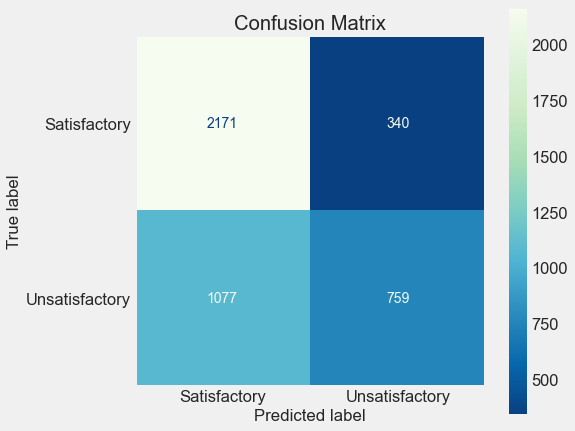

,Accuracy,F1,Recall,Precision
0,0.674028,0.517206,0.413399,0.690628


time: 264 ms


In [179]:
f.confusion_report(mnb_assess, X_test, y_test)

## KNeighborsClassifier

In [180]:
knn_assess = make_pipeline(preprocessing_mm, KNN)

time: 1.08 ms


### Fitting Model

In [181]:
knn_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1029b55b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10dd1dfa0>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1))])

time: 70 ms


In [182]:
# f.pickle_model(knn_assess, 'knn_assess')

time: 742 µs


### Cross Val Scores

In [183]:
# checking cross val scores
modeling.report(knn_assess, X_train, y_train, 'knn_assess',\
                'KNN ASSESS/MinMax()')

knn_assess has an average Accuracy of 0.7024303079721654
knn_assess has an average F1 of 0.6203125893917579
knn_assess has an average Recall of 0.5757320106618138
knn_assess has an average Precision of 0.6725866739389852


[0.7024303079721654,
 0.6203125893917579,
 0.5757320106618138,
 0.6725866739389852]

time: 6.71 s


### Test Data Confusion Matrix

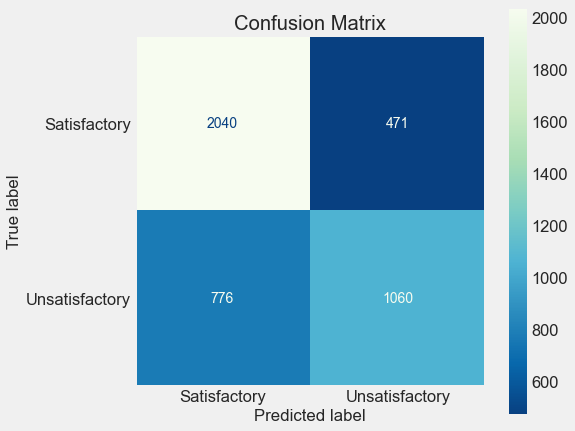

,Accuracy,F1,Recall,Precision
0,0.713135,0.629641,0.577342,0.692358


time: 14.1 s


In [184]:
f.confusion_report(knn_assess, X_test, y_test)

## Logistic Regression Classifier

In [185]:
logreg_assess = make_pipeline(preprocessing_mm, LR)

time: 1.19 ms


### Fitting Model

In [186]:
logreg_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1029b55b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10dd1dfa0>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1,
                                    random_state=2021))])

time: 252 ms


In [187]:
# f.pickle_model(logreg_assess, 'logreg_assess')

time: 734 µs


### Cross Val Scores

In [188]:
# checking cross val scores
modeling.report(logreg_assess, X_train, y_train, 'logreg_assess',\
                'LogReg ASSESS/MinMax()')

logreg_assess has an average Accuracy of 0.7996005916115413
logreg_assess has an average F1 of 0.7600933613194757
logreg_assess has an average Recall of 0.7517238082521911
logreg_assess has an average Precision of 0.7686806347383531


[0.7996005916115413,
 0.7600933613194757,
 0.7517238082521911,
 0.7686806347383531]

time: 1.09 s


### Test Data Confusion Matrix

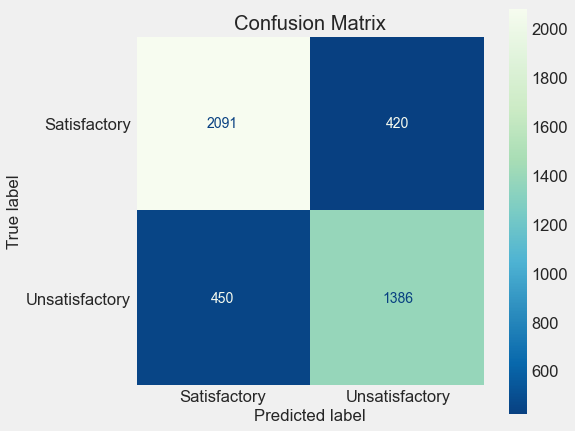

,Accuracy,F1,Recall,Precision
0,0.799862,0.76112,0.754902,0.767442


time: 278 ms


In [189]:
f.confusion_report(logreg_assess, X_test, y_test)

## Support Vector Machine

In [190]:
svc_assess= make_pipeline(preprocessing_mm, SVC)

time: 976 µs


### Fitting Model

In [191]:
svc_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1029b55b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10dd1dfa0>)])),
                ('svc', SVC())])

time: 7.85 s


In [192]:
# f.pickle_model(svc_assess, 'svc_assess')

time: 640 µs


### Cross Val Scores

In [193]:
# checking cross val scores
modeling.report(svc_assess, X_train, y_train, 'svc_assess',\
                'Support Vector CLF ASSESS/MinMax()')

svc_assess has an average Accuracy of 0.8004443852205366
svc_assess has an average F1 of 0.7574987891531333
svc_assess has an average Recall of 0.7381057642697366
svc_assess has an average Precision of 0.7779930104692584


[0.8004443852205366,
 0.7574987891531333,
 0.7381057642697366,
 0.7779930104692584]

time: 29.3 s


### Test Data Confusion Matrix

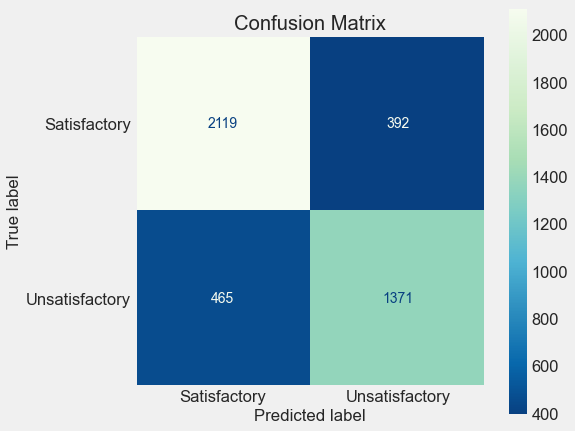

,Accuracy,F1,Recall,Precision
0,0.802853,0.761878,0.746732,0.777652


time: 8.67 s


In [194]:
f.confusion_report(svc_assess, X_test, y_test)

## Linear Support Vector Machine

In [195]:
lsvc_assess = make_pipeline(preprocessing_mm, LSVC)

time: 1.03 ms


### Fitting Model

In [196]:
lsvc_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1029b55b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10dd1dfa0>)])),
                ('linearsvc', LinearSVC())])

time: 217 ms


In [197]:
# f.pickle_model(lsvc_assess, 'lsvc_assess')

time: 765 µs


### Cross Val Scores

In [198]:
# checking cross val scores
modeling.report(lsvc_assess, X_train, y_train, 'lsvc_assess',\
                'Linear SVC ASSESS/MinMax()')

lsvc_assess has an average Accuracy of 0.7994473350418058
lsvc_assess has an average F1 of 0.7617280261536308
lsvc_assess has an average Recall of 0.7591702642870448
lsvc_assess has an average Precision of 0.7643222322452904


[0.7994473350418058,
 0.7617280261536308,
 0.7591702642870448,
 0.7643222322452904]

time: 933 ms


### Test Data Confusion Matrix

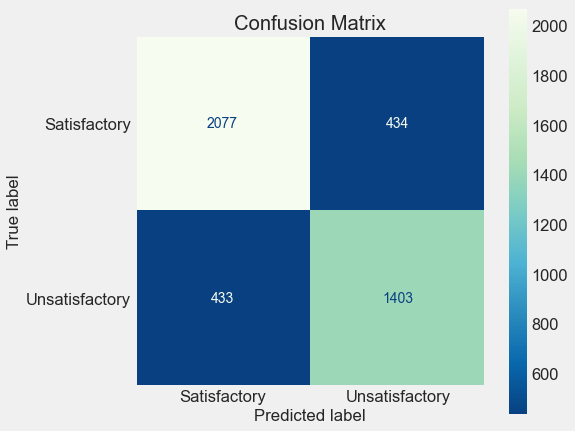

,Accuracy,F1,Recall,Precision
0,0.800552,0.763953,0.764161,0.763745


time: 257 ms


In [199]:
f.confusion_report(lsvc_assess, X_test, y_test)

## Decision Tree

In [200]:
dt_assess = make_pipeline(preprocessing_mm, DT)

time: 1.5 ms


### Fitting Model

In [201]:
dt_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1029b55b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10dd1dfa0>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=2021))])

time: 495 ms


In [202]:
# f.pickle_model(dt_assess, 'dt_assess')

time: 703 µs


### Cross Val Scores

In [203]:
# checking cross val scores
modeling.report(dt_assess, X_train, y_train, 'dt_assess',\
                'Decision Tree CLF ASSESS/MinMax()')

dt_assess has an average Accuracy of 0.8132523691524236
dt_assess has an average F1 of 0.7796877311400623
dt_assess has an average Recall of 0.7826002100054232
dt_assess has an average Precision of 0.7769495493638934


[0.8132523691524236,
 0.7796877311400623,
 0.7826002100054232,
 0.7769495493638934]

time: 1.84 s


### Test Data Confusion Matrix

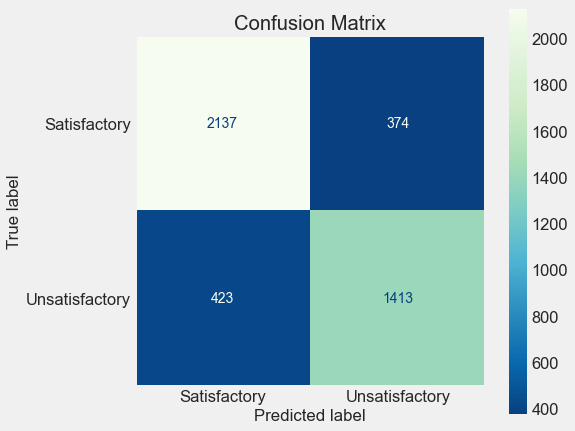

,Accuracy,F1,Recall,Precision
0,0.816655,0.780017,0.769608,0.790711


time: 270 ms


In [204]:
f.confusion_report(dt_assess, X_test, y_test)

## Bagging Classifier

In [205]:
bclf_assess = make_pipeline(preprocessing_mm, BCLF)

time: 911 µs


### Fitting Model

In [206]:
bclf_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1029b55b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10dd1dfa0>)])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                   random_state=2021))])

time: 2.67 s


In [207]:
# f.pickle_model(bclf_assess, 'bclf_assess')

time: 718 µs


### Cross Val Scores

In [208]:
# checking cross val scores
modeling.report(bclf_assess, X_train, y_train, 'bclf_assess',\
                'Bagging CLF ASSESS/MinMax()')

bclf_assess has an average Accuracy of 0.8571978815882675
bclf_assess has an average F1 of 0.8198418992440043
bclf_assess has an average Recall of 0.7695228393260705
bclf_assess has an average Precision of 0.8774237357279111


[0.8571978815882675,
 0.8198418992440043,
 0.7695228393260705,
 0.8774237357279111]

time: 10.1 s


### Test Data Confusion Matrix

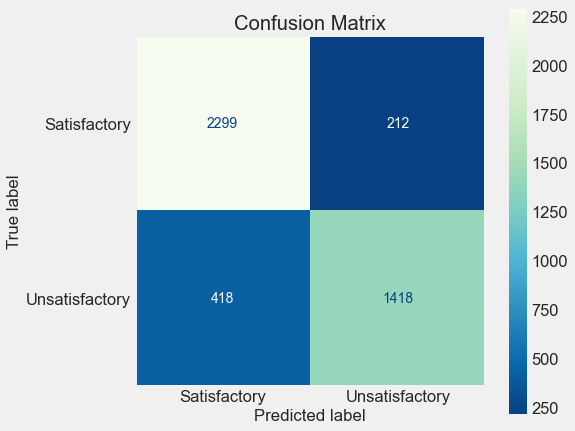

,Accuracy,F1,Recall,Precision
0,0.855072,0.818234,0.772331,0.869939


time: 327 ms


In [209]:
f.confusion_report(bclf_assess, X_test, y_test)

## Random Forest Classifier

In [210]:
rf_assess = make_pipeline(preprocessing_mm, RF)

time: 1.09 ms


### Fitting Model

In [211]:
rf_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1029b55b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10dd1dfa0>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2021))])

time: 2.49 s


In [212]:
# f.pickle_model(rf_assess, 'rf_assess')

time: 677 µs


### Cross Val Scores

In [213]:
# checking cross val scores
modeling.report(rf_assess, X_train, y_train, 'rf_assess',\
                'Random Forest ASSESS/MinMax()')

rf_assess has an average Accuracy of 0.8641766151065677
rf_assess has an average F1 of 0.8326558974827559
rf_assess has an average Recall of 0.8002197309490959
rf_assess has an average Precision of 0.8678995102749522


[0.8641766151065677,
 0.8326558974827559,
 0.8002197309490959,
 0.8678995102749522]

time: 11.4 s


### Test Data Confusion Matrix

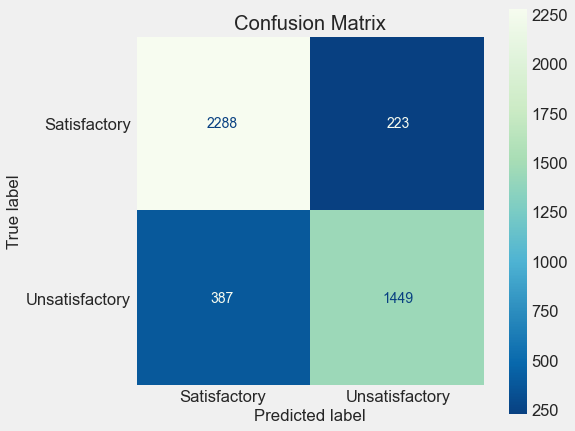

,Accuracy,F1,Recall,Precision
0,0.859673,0.826112,0.789216,0.866627


time: 567 ms


In [214]:
f.confusion_report(rf_assess, X_test, y_test)

## AdaBoost

In [215]:
ada_assess = make_pipeline(preprocessing_mm, ADA)

time: 1.09 ms


### Fitting Model

In [216]:
ada_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1029b55b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10dd1dfa0>)])),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                    random_state=2021))])

time: 478 ms


In [217]:
# f.pickle_model(ada_assess, 'ada_assess')

time: 750 µs


### Cross Val Scores

In [218]:
# checking cross val scores
modeling.report(ada_assess, X_train, y_train, 'ada_assess',\
                'AdaBoost ASSESS/MinMax()')

ada_assess has an average Accuracy of 0.8137894437110091
ada_assess has an average F1 of 0.7802055990342914
ada_assess has an average Recall of 0.78278169820869
ada_assess has an average Precision of 0.7778046950366233


[0.8137894437110091, 0.7802055990342914, 0.78278169820869, 0.7778046950366233]

time: 1.95 s


### Test Data Confusion Matrix

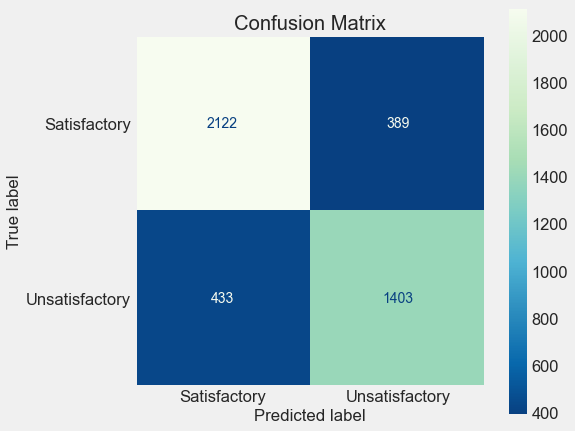

,Accuracy,F1,Recall,Precision
0,0.810904,0.773429,0.764161,0.782924


time: 274 ms


In [219]:
f.confusion_report(ada_assess, X_test, y_test)

## XGBoost

In [220]:
xgb_assess = make_pipeline(preprocessing_mm, XGB)

time: 967 µs


### Fitting Model

In [221]:
%%capture --no-display
xgb_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1029b55b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10dd1dfa0>)])),
                ('xgbclassifier',
                 XGBClassifier(ba...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estima

time: 1.93 s


In [222]:
# f.pickle_model(xgb_assess, 'xgb_assess')

time: 740 µs


### Cross Val Scores

In [223]:
%%capture --no-display
# checking cross val scores
modeling.report(xgb_assess, X_train, y_train, 'xgb_assess',\
                'XGBoost ASSESS/MinMax()')

[0.8648672403933724,
 0.8320437583139393,
 0.7925904679956022,
 0.8757103191866864]

time: 8.29 s


### Test Data Confusion Matrix

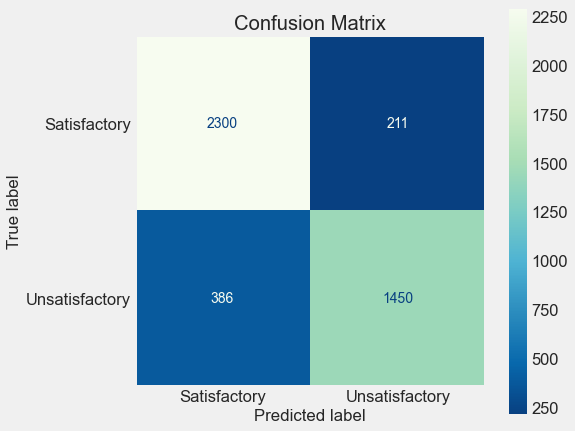

,Accuracy,F1,Recall,Precision
0,0.862664,0.829282,0.78976,0.872968


time: 443 ms


In [224]:
%%capture --no-display
f.confusion_report(xgb_assess, X_test, y_test)

## Model Summary 5

In [225]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,mnb_assess,0.675512,0.523229,0.421539,0.690241,0.347227,Naive Bayes ASSESS/MinMax()
1,mnb_svsi,0.651152,0.600492,0.558031,0.649992,0.350796,Naive Bayes SVSI/MinMax()
2,dt,0.553202,0.574815,0.568223,0.581733,0.945038,Decision Tree
3,knn_assess,0.702430,0.620313,0.575732,0.672587,6.701119,KNN ASSESS/MinMax()
4,knn,0.547380,0.578151,0.583360,0.573258,9.082440,KNN
5,bclf,0.553202,0.598854,0.627375,0.572959,5.447410,Bagging CLF
6,rf,0.555314,0.600392,0.628341,0.574887,11.738072,Random Forest
7,xgb,0.562393,0.607038,0.635963,0.580811,2.689889,XGBoost
8,ada,0.554858,0.605257,0.642083,0.572621,4.695330,AdaBoost
9,knn_svsi,0.683861,0.658643,0.649086,0.668497,7.159089,KNN SVSI/MinMax()


time: 17.7 ms


## Voting Classifier
Using the top three model in a voting classifier.

In [226]:
clf1 = BCLF
clf2 = RF
clf3 = XGB

estimators = [('bclf', clf1), ('rf', clf2), ('xgb', clf3)]

VC = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1)

time: 1.32 ms


In [227]:
vc_assess = make_pipeline(preprocessing_mm, VC)

time: 1.01 ms


### Fitting Model

In [228]:
%%capture --no-display
vc_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1029b55b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10dd1dfa0>)])),
                ('votingclassifier',
                 VotingClassif...
                                                             interaction_constraints='',
                                                             learning_rate=0.300000012,
                                                             max_delta_step=0,
                                                             max_depth=6,
   

time: 5.46 s


In [229]:
# f.pickle_model(vc_assess, 'vc_assess')

time: 756 µs


### Cross Val Scores

In [230]:
%%capture --no-display
# checking cross val scores
modeling.report(vc_assess, X_train, y_train, 'vc_assess',\
                'Voting CLF ASSESS/MinMax()')

[0.8699286783341688, 0.837407860032239, 0.7931359216419326, 0.8869690989342516]

time: 21.7 s


### Test Data Confusion Matrix

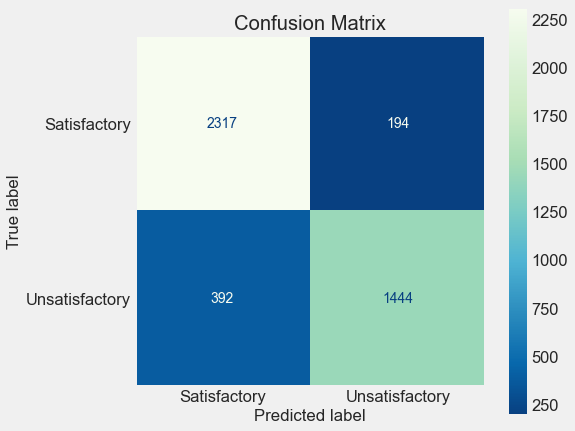

,Accuracy,F1,Recall,Precision
0,0.865194,0.831318,0.786492,0.881563


time: 1.1 s


In [231]:
%%capture --no-display
f.confusion_report(vc_assess, X_test, y_test)

## Model Summary 6

In [232]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,mnb_assess,0.675512,0.523229,0.421539,0.690241,0.347227,Naive Bayes ASSESS/MinMax()
1,mnb_svsi,0.651152,0.600492,0.558031,0.649992,0.350796,Naive Bayes SVSI/MinMax()
2,dt,0.553202,0.574815,0.568223,0.581733,0.945038,Decision Tree
3,knn_assess,0.702430,0.620313,0.575732,0.672587,6.701119,KNN ASSESS/MinMax()
4,knn,0.547380,0.578151,0.583360,0.573258,9.082440,KNN
5,bclf,0.553202,0.598854,0.627375,0.572959,5.447410,Bagging CLF
6,rf,0.555314,0.600392,0.628341,0.574887,11.738072,Random Forest
7,xgb,0.562393,0.607038,0.635963,0.580811,2.689889,XGBoost
8,ada,0.554858,0.605257,0.642083,0.572621,4.695330,AdaBoost
9,knn_svsi,0.683861,0.658643,0.649086,0.668497,7.159089,KNN SVSI/MinMax()


time: 14.6 ms


## Neural Network

In [233]:
def create_model():
    # building model
    model = Sequential()
    model.add(Dense(64, input_dim=40, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    return model

time: 1.81 ms


In [234]:
NN2 = KerasClassifier(build_fn=create_model,
                     epochs=10,
                     batch_size=32,
                     verbose=0)

time: 1.19 ms


### Pipeline

In [235]:
nn_assess = make_pipeline(preprocessing_mm, NN2)

time: 1.36 ms


### Fitting Models

In [236]:
%%capture --no-display
nn_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1029b55b0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10dd1dfa0>)])),
                ('kerasclassifier',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x17e48f4f0>)])

time: 6.04 s


### Cross Val Scores

In [237]:
%%capture --no-display
modeling.report(nn_assess, X_train, y_train, 'nn_assess',\
                'Neural Net ASSESS/MinMax()')

[0.7996782788669485,
 0.7564109698334665,
 0.7404248951246505,
 0.7790558378466633]

time: 26 s


### Test Data Confusion Matrix

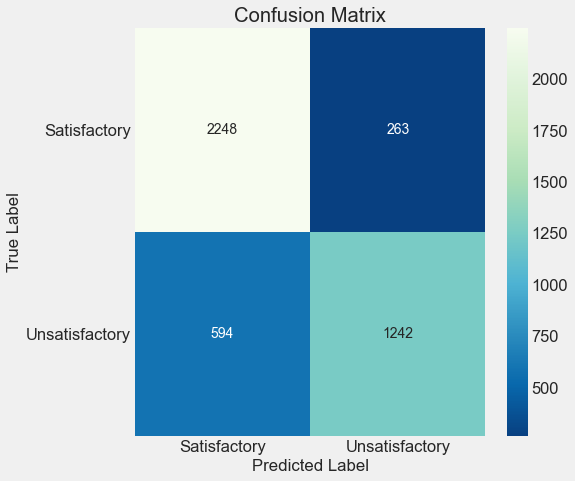

,Accuracy,F1,Recall,Precision
0,0.802853,0.74349,0.676471,0.825249


time: 825 ms


In [238]:
%%capture --no-display
f.confusion_report_nn(nn_assess, X_test, y_test)

## Model Summary 7

In [239]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,mnb_assess,0.675512,0.523229,0.421539,0.690241,0.347227,Naive Bayes ASSESS/MinMax()
1,mnb_svsi,0.651152,0.600492,0.558031,0.649992,0.350796,Naive Bayes SVSI/MinMax()
2,dt,0.553202,0.574815,0.568223,0.581733,0.945038,Decision Tree
3,knn_assess,0.702430,0.620313,0.575732,0.672587,6.701119,KNN ASSESS/MinMax()
4,knn,0.547380,0.578151,0.583360,0.573258,9.082440,KNN
5,bclf,0.553202,0.598854,0.627375,0.572959,5.447410,Bagging CLF
6,rf,0.555314,0.600392,0.628341,0.574887,11.738072,Random Forest
7,xgb,0.562393,0.607038,0.635963,0.580811,2.689889,XGBoost
8,ada,0.554858,0.605257,0.642083,0.572621,4.695330,AdaBoost
9,knn_svsi,0.683861,0.658643,0.649086,0.668497,7.159089,KNN SVSI/MinMax()


time: 31.2 ms


# SS Test

## KNeighborsClassifier

In [240]:
knn_ss = make_pipeline(preprocessing_ss, KNN)

time: 1.9 ms


### Fitting Model

In [241]:
knn_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1029b55b0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10dd1dfa0>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1))])

time: 63.1 ms


In [242]:
# f.pickle_model(knn_ss, 'knn_ss')

time: 735 µs


### Cross Val Scores

In [243]:
# checking cross val scores
modeling.report(knn_ss, X_train, y_train, 'knn_ss',\
                'KNN SS()')

knn_ss has an average Accuracy of 0.7981428304164578
knn_ss has an average F1 of 0.7524748177223779
knn_ss has an average Recall of 0.7266642600111102
knn_ss has an average Precision of 0.7803188599605039


[0.7981428304164578,
 0.7524748177223779,
 0.7266642600111102,
 0.7803188599605039]

time: 6.79 s


### Test Data Confusion Matrix

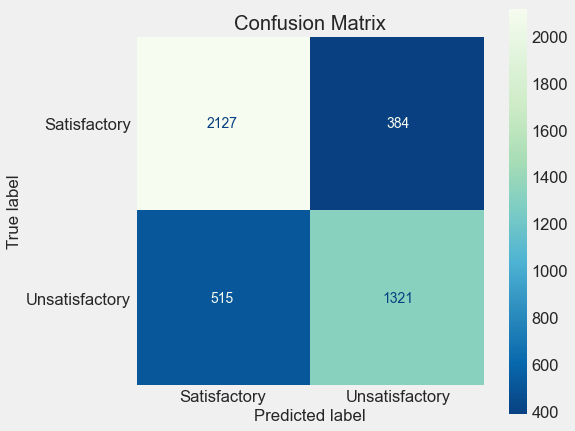

,Accuracy,F1,Recall,Precision
0,0.793191,0.746117,0.719499,0.77478


time: 14.6 s


In [244]:
f.confusion_report(knn_ss, X_test, y_test)

## Logistic Regression Classifier

In [245]:
logreg_ss = make_pipeline(preprocessing_ss, LR)

time: 1.2 ms


### Fitting Model

In [246]:
logreg_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1029b55b0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10dd1dfa0>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1,
                                    random_state=2021))])

time: 338 ms


In [247]:
# f.pickle_model(logreg_ss, 'logreg_ss')

time: 747 µs


### Cross Val Scores

In [248]:
# checking cross val scores
modeling.report(logreg_ss, X_train, y_train, 'logreg_ss',\
                'LogReg SS()')

logreg_ss has an average Accuracy of 0.799907428325344
logreg_ss has an average F1 of 0.7611876400560381
logreg_ss has an average Recall of 0.7551737325084769
logreg_ss has an average Precision of 0.7673285746981365


[0.799907428325344, 0.7611876400560381, 0.7551737325084769, 0.7673285746981365]

time: 1.15 s


### Test Data Confusion Matrix

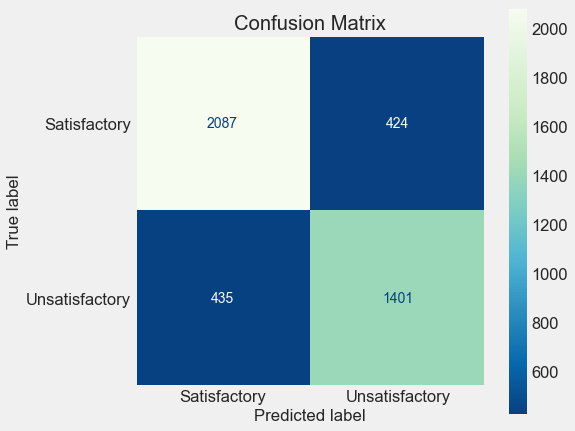

,Accuracy,F1,Recall,Precision
0,0.802392,0.765365,0.763072,0.767671


time: 444 ms


In [249]:
f.confusion_report(logreg_ss, X_test, y_test)

## Support Vector Machine

In [250]:
svc_ss = make_pipeline(preprocessing_ss, SVC)

time: 1.22 ms


### Fitting Model

In [251]:
svc_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1029b55b0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10dd1dfa0>)])),
                ('svc', SVC())])

time: 7.73 s


In [252]:
# f.pickle_model(svc_ss, 'svc_ss')

time: 802 µs


### Cross Val Scores

In [253]:
# checking cross val scores
modeling.report(svc_ss, X_train, y_train, 'svc_ss',\
                'Support Vector CLF SS()')

svc_ss has an average Accuracy of 0.8325783755862579
svc_ss has an average F1 of 0.7956609552871647
svc_ss has an average Recall of 0.7718877905088758
svc_ss has an average Precision of 0.8209867097507779


[0.8325783755862579,
 0.7956609552871647,
 0.7718877905088758,
 0.8209867097507779]

time: 31.6 s


### Test Data Confusion Matrix

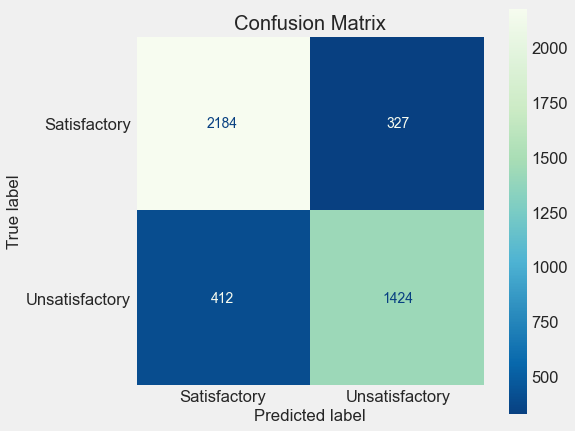

,Accuracy,F1,Recall,Precision
0,0.829998,0.793978,0.775599,0.81325


time: 7.67 s


In [254]:
f.confusion_report(svc_ss, X_test, y_test)

## Linear Support Vector Machine

In [255]:
lsvc_ss = make_pipeline(preprocessing_ss, LSVC)

time: 1.39 ms


### Fitting Model

In [256]:
lsvc_ss.fit(X_train, y_train)

/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1029b55b0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10dd1dfa0>)])),
                ('linearsvc', LinearSVC())])

time: 1.07 s


In [257]:
# f.pickle_model(lsvc_ss, 'lsvc_ss')

time: 808 µs


### Cross Val Scores

In [258]:
# checking cross val scores
modeling.report(lsvc_ss, X_train, y_train, 'lsvc_ss',\
                'Linear SVC SS()')

/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


lsvc_ss has an average Accuracy of 0.799677396391499
lsvc_ss has an average F1 of 0.762240896610715
lsvc_ss has an average Recall of 0.7604416707464423
lsvc_ss has an average Precision of 0.7640795484878435


/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[0.799677396391499, 0.762240896610715, 0.7604416707464423, 0.7640795484878435]

time: 3.23 s


### Test Data Confusion Matrix

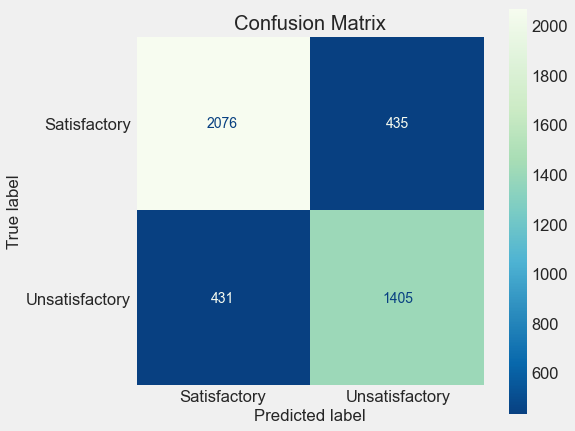

,Accuracy,F1,Recall,Precision
0,0.800782,0.764418,0.765251,0.763587


time: 356 ms


In [259]:
f.confusion_report(lsvc_ss, X_test, y_test)

## Decision Tree

In [260]:
dt_ss = make_pipeline(preprocessing_ss, DT)

time: 1.12 ms


### Fitting Model

In [261]:
dt_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1029b55b0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10dd1dfa0>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=2021))])

time: 474 ms


In [262]:
# f.pickle_model(dt_ss, 'dt_ss')

time: 998 µs


### Cross Val Scores

In [263]:
# checking cross val scores
modeling.report(dt_ss, X_train, y_train, 'dt_ss',\
                'Decision Tree CLF SS()')

dt_ss has an average Accuracy of 0.8130989655034464
dt_ss has an average F1 of 0.7795935233860044
dt_ss has an average Recall of 0.7827820278875334
dt_ss has an average Precision of 0.7765643542429371


[0.8130989655034464,
 0.7795935233860044,
 0.7827820278875334,
 0.7765643542429371]

time: 1.98 s


### Test Data Confusion Matrix

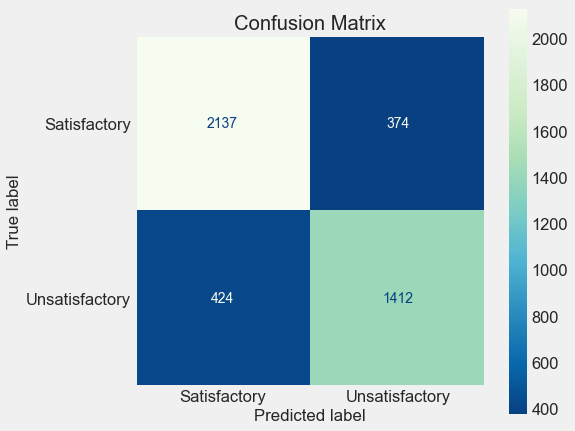

,Accuracy,F1,Recall,Precision
0,0.816425,0.77968,0.769063,0.790594


time: 364 ms


In [264]:
f.confusion_report(dt_ss, X_test, y_test)

## Bagging Classifier

In [265]:
bclf_ss = make_pipeline(preprocessing_ss, BCLF)

time: 1.12 ms


### Fitting Model

In [266]:
bclf_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1029b55b0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10dd1dfa0>)])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                   random_state=2021))])

time: 3.17 s


In [267]:
# f.pickle_model(bclf_ss, 'bclf_ss')

time: 937 µs


### Cross Val Scores

In [268]:
# checking cross val scores
modeling.report(bclf_ss, X_train, y_train, 'bclf_ss',\
                'Bagging CLF SS()')

bclf_ss has an average Accuracy of 0.8575046300545253
bclf_ss has an average F1 of 0.8201911049129069
bclf_ss has an average Recall of 0.7697044923687589
bclf_ss has an average Precision of 0.877980416190016


[0.8575046300545253, 0.8201911049129069, 0.7697044923687589, 0.877980416190016]

time: 12.4 s


### Test Data Confusion Matrix

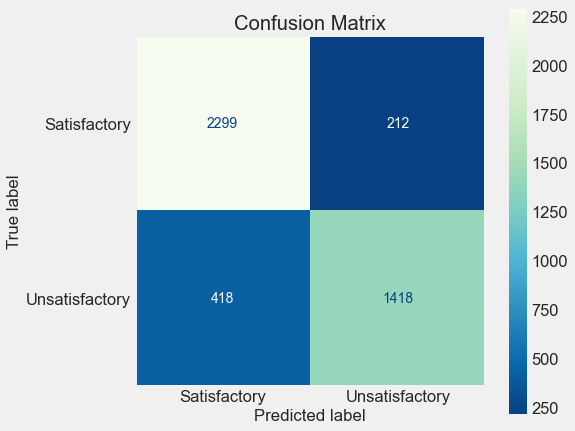

,Accuracy,F1,Recall,Precision
0,0.855072,0.818234,0.772331,0.869939


time: 412 ms


In [269]:
f.confusion_report(bclf_ss, X_test, y_test)

## Random Forest Classifier

In [270]:
rf_ss = make_pipeline(preprocessing_ss, RF)

time: 1.6 ms


### Fitting Model

In [271]:
rf_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1029b55b0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10dd1dfa0>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2021))])

time: 3.23 s


In [272]:
# f.pickle_model(rf_ss, 'rf_ss')

time: 1.37 ms


### Cross Val Scores

In [273]:
# checking cross val scores
modeling.report(rf_ss, X_train, y_train, 'rf_ss',\
                'Random Forest SS()')

rf_ss has an average Accuracy of 0.8639464949251778
rf_ss has an average F1 of 0.8323575921286904
rf_ss has an average Recall of 0.7998562600242974
rf_ss has an average Precision of 0.8676748083889949


[0.8639464949251778,
 0.8323575921286904,
 0.7998562600242974,
 0.8676748083889949]

time: 12.7 s


### Test Data Confusion Matrix

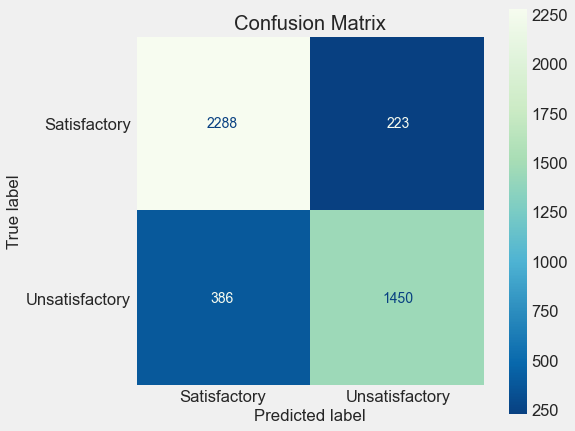

,Accuracy,F1,Recall,Precision
0,0.859903,0.826446,0.78976,0.866707


time: 623 ms


In [274]:
f.confusion_report(rf_ss, X_test, y_test)

## AdaBoost

In [275]:
ada_ss = make_pipeline(preprocessing_ss, ADA)

time: 1.17 ms


### Fitting Model

In [276]:
ada_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1029b55b0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10dd1dfa0>)])),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                    random_state=2021))])

time: 552 ms


In [277]:
# f.pickle_model(ada_ss, 'ada_ss')

time: 771 µs


### Cross Val Scores

In [278]:
# checking cross val scores
modeling.report(ada_ss, X_train, y_train, 'ada_ss',\
                'AdaBoost SS()')

ada_ss has an average Accuracy of 0.8136360106461838
ada_ss has an average F1 of 0.7800307320800093
ada_ss has an average Recall of 0.782600374844845
ada_ss has an average Precision of 0.7776218807428256


[0.8136360106461838, 0.7800307320800093, 0.782600374844845, 0.7776218807428256]

time: 1.84 s


### Test Data Confusion Matrix

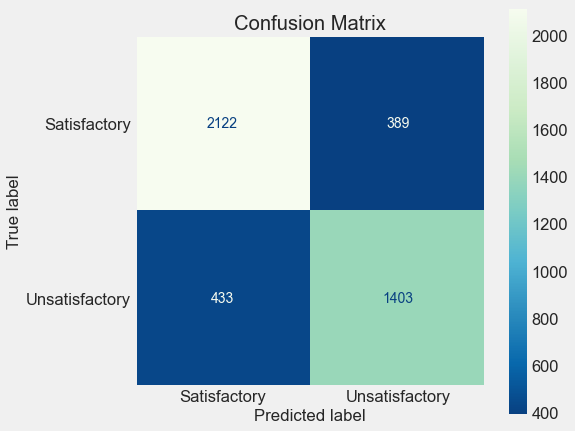

,Accuracy,F1,Recall,Precision
0,0.810904,0.773429,0.764161,0.782924


time: 289 ms


In [279]:
f.confusion_report(ada_ss, X_test, y_test)

## XGBoost

In [280]:
xgb_ss = make_pipeline(preprocessing_ss, XGB)

time: 1.01 ms


### Fitting Model

In [281]:
%%capture --no-display
xgb_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1029b55b0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10dd1dfa0>)])),
                ('xgbclassifier',
                 XGBClassifie...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estima

time: 937 ms


In [282]:
# f.pickle_model(xgb_ss, 'xgb_ss')

time: 748 µs


### Cross Val Scores

In [283]:
%%capture --no-display
# checking cross val scores
modeling.report(xgb_ss, X_train, y_train, 'xgb_ss',\
                'XGBoost SS()')

[0.865020791121591, 0.8326708653940724, 0.7953157581541942, 0.8737832664784427]

time: 4.12 s


### Test Data Confusion Matrix

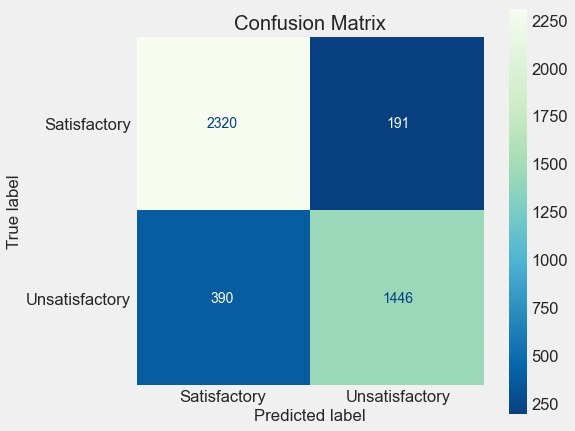

,Accuracy,F1,Recall,Precision
0,0.866345,0.832709,0.787582,0.883323


time: 392 ms


In [284]:
%%capture --no-display
f.confusion_report(xgb_ss, X_test, y_test)

## Model Summary 8

In [285]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,mnb_assess,0.675512,0.523229,0.421539,0.690241,0.347227,Naive Bayes ASSESS/MinMax()
1,mnb_svsi,0.651152,0.600492,0.558031,0.649992,0.350796,Naive Bayes SVSI/MinMax()
2,dt,0.553202,0.574815,0.568223,0.581733,0.945038,Decision Tree
3,knn_assess,0.702430,0.620313,0.575732,0.672587,6.701119,KNN ASSESS/MinMax()
4,knn,0.547380,0.578151,0.583360,0.573258,9.082440,KNN
5,bclf,0.553202,0.598854,0.627375,0.572959,5.447410,Bagging CLF
6,rf,0.555314,0.600392,0.628341,0.574887,11.738072,Random Forest
7,xgb,0.562393,0.607038,0.635963,0.580811,2.689889,XGBoost
8,ada,0.554858,0.605257,0.642083,0.572621,4.695330,AdaBoost
9,knn_svsi,0.683861,0.658643,0.649086,0.668497,7.159089,KNN SVSI/MinMax()


time: 21.1 ms


## Voting Classifier
Using the top three model in a voting classifier.

In [286]:
clf1 = BCLF
clf2 = RF
clf3 = XGB

estimators = [('bclf',clf1), ('rf', clf2), ('xgb', clf3)]

VC = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1)

time: 1.1 ms


In [287]:
vc_ss = make_pipeline(preprocessing_ss, VC)

time: 1.36 ms


### Fitting Model

In [288]:
%%capture --no-display
vc_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1029b55b0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10dd1dfa0>)])),
                ('votingclassifier',
                 VotingCla...
                                                             interaction_constraints='',
                                                             learning_rate=0.300000012,
                                                             max_delta_step=0,
                                                             max_depth=6,
   

time: 5.48 s


In [289]:
# f.pickle_model(vc_ss, 'vc_ss')

time: 906 µs


### Cross Val Scores

In [290]:
%%capture --no-display
# checking cross val scores
modeling.report(vc_ss, X_train, y_train, 'vc_ss',\
                'Voting CLF SS()')

[0.8692385825326339, 0.8366929014397682, 0.7931354271236675, 0.88536071601542]

time: 21.6 s


### Test Data Confusion Matrix

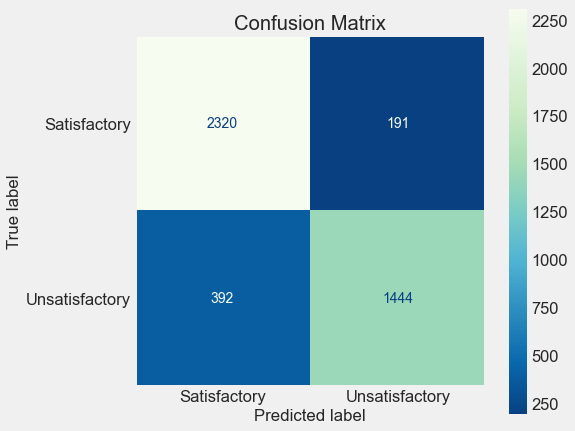

,Accuracy,F1,Recall,Precision
0,0.865885,0.832037,0.786492,0.88318


time: 1.2 s


In [291]:
%%capture --no-display
f.confusion_report(vc_ss, X_test, y_test)

## Model Summary 9

In [292]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,mnb_assess,0.675512,0.523229,0.421539,0.690241,0.347227,Naive Bayes ASSESS/MinMax()
1,mnb_svsi,0.651152,0.600492,0.558031,0.649992,0.350796,Naive Bayes SVSI/MinMax()
2,dt,0.553202,0.574815,0.568223,0.581733,0.945038,Decision Tree
3,knn_assess,0.702430,0.620313,0.575732,0.672587,6.701119,KNN ASSESS/MinMax()
4,knn,0.547380,0.578151,0.583360,0.573258,9.082440,KNN
5,bclf,0.553202,0.598854,0.627375,0.572959,5.447410,Bagging CLF
6,rf,0.555314,0.600392,0.628341,0.574887,11.738072,Random Forest
7,xgb,0.562393,0.607038,0.635963,0.580811,2.689889,XGBoost
8,ada,0.554858,0.605257,0.642083,0.572621,4.695330,AdaBoost
9,knn_svsi,0.683861,0.658643,0.649086,0.668497,7.159089,KNN SVSI/MinMax()


time: 27.6 ms


## Neural Network

### Pipeline

In [293]:
nn_ss = make_pipeline(preprocessing_ss, NN2)

time: 1.18 ms


### Fitting Models

In [294]:
%%capture --no-display
nn_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1029b55b0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10dd1dfa0>)])),
                ('kerasclassifier',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x17e48f4f0>)])

time: 7.43 s


### Cross Val Scores

In [295]:
%%capture --no-display
modeling.report(nn_ss, X_train, y_train, 'nn_ss',\
                'Neural Net SS()')

[0.8496046215827608,
 0.8119007815281429,
 0.7693497911062975,
 0.8608380990007708]

time: 24.1 s


### Test Data Confusion Matrix

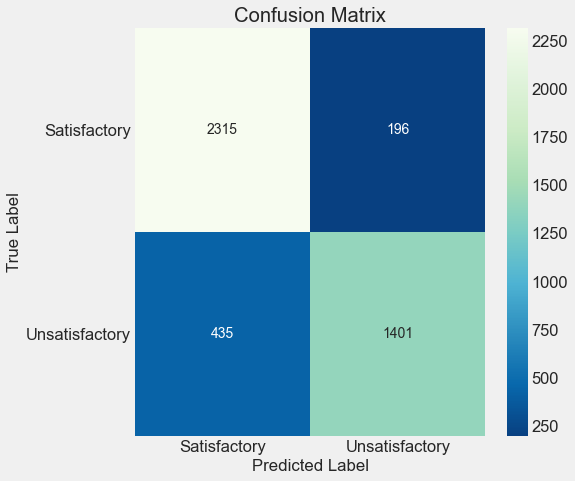

,Accuracy,F1,Recall,Precision
0,0.854842,0.816196,0.763072,0.87727


time: 892 ms


In [296]:
%%capture --no-display
f.confusion_report_nn(nn_ss, X_test, y_test)

## Model Summary 10

In [297]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,mnb_assess,0.675512,0.523229,0.421539,0.690241,0.347227,Naive Bayes ASSESS/MinMax()
1,mnb_svsi,0.651152,0.600492,0.558031,0.649992,0.350796,Naive Bayes SVSI/MinMax()
2,dt,0.553202,0.574815,0.568223,0.581733,0.945038,Decision Tree
3,knn_assess,0.702430,0.620313,0.575732,0.672587,6.701119,KNN ASSESS/MinMax()
4,knn,0.547380,0.578151,0.583360,0.573258,9.082440,KNN
5,bclf,0.553202,0.598854,0.627375,0.572959,5.447410,Bagging CLF
6,rf,0.555314,0.600392,0.628341,0.574887,11.738072,Random Forest
7,xgb,0.562393,0.607038,0.635963,0.580811,2.689889,XGBoost
8,ada,0.554858,0.605257,0.642083,0.572621,4.695330,AdaBoost
9,knn_svsi,0.683861,0.658643,0.649086,0.668497,7.159089,KNN SVSI/MinMax()


time: 19 ms


In [298]:
Audio(sound_file, autoplay=True)

time: 32.4 ms


In [299]:
%%capture --no-display
# ma_df = modeling.history
# f.df_plot(ma_df, 'modeling_history')

time: 1.16 ms
